In [1]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp, odeint
import cvxpy as cp
import dccp

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2, TwoLocal

from qiskit.quantum_info import SparsePauliOp, Statevector, Operator

from qiskit.utils import QuantumInstance

from qiskit import Aer
from qiskit.opflow import I,X,Y,Z
from qiskit.opflow.expectations import PauliExpectation
from qiskit.opflow.converters import CircuitSampler
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms.optimizers import SPSA, SLSQP, ADAM
from qiskit.algorithms import VQE, NumPyMinimumEigensolver

import itertools
import random
import matplotlib.pylab as plt

/var/folders/km/wpxhny5j6h7c_prrd3x7j1mc0000gn/T/ipykernel_31417/2182670273.py:17: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I,X,Y,Z


In [2]:
def local_op_basis(num_qubits):
    pauli_type = ['I','X','Y','Z']
    I = np.eye(2)
    X = np.array([[0,1+0.j],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1+0.j,0],[0,-1]])
    gate_dict = {'X': X, 'Y': Y, 'Z': Z}

    L_str_list = []
    L_mat_list = []
    L_1q_list = []

    # Single qubit op
    for n in range(num_qubits):
        for pauli in ['X','Y','Z']:
            pauli_str = 'I'*n + pauli + 'I'*(num_qubits-n-1)
            if pauli_str != 'I'*num_qubits:
                L_str_list.append(pauli_str)
                L_1q_list.append(pauli_str)

                mat = np.kron(np.kron(np.eye(2**n), gate_dict[pauli]), np.eye(2**(num_qubits-n-1)))
                L_mat_list.append(mat)
            

    # Two-local op
    for n in range(num_qubits):
        for pauli1 in ['X','Y','Z']:
            for pauli2 in ['X','Y','Z']:
                        
                gate_str = list('I'*num_qubits)
                gate_str[n] = pauli1
                gate_str[(n+1) % num_qubits] = pauli2
                L_str_list.append(''.join(gate_str))

                if n != num_qubits - 1:
                    mat = np.kron(np.kron(np.kron(np.eye(2**n), gate_dict[pauli1]), gate_dict[pauli2]), np.eye(2**(num_qubits-n-2)))
                else:
                    mat = np.kron(np.kron(gate_dict[pauli2], np.eye(2**(num_qubits - 2))), gate_dict[pauli1])
                L_mat_list.append(mat)
                
                
    L_dict = dict(zip(L_str_list, L_mat_list))
    return L_dict, L_1q_list

In [3]:
def local_op_basis_v2(num_qubits, k):
    assert num_qubits >= k
    pauli_type = ['I','X','Y','Z']
    gate_dict = {'X': X, 'Y': Y, 'Z': Z}
    L_list = []
    for n in range(num_qubits):
        all_local_ops = itertools.product(['I','X','Y','Z'], repeat=k)
        for local_op in all_local_ops:
            pauli_str = ['I'] * num_qubits
            for i,char in enumerate(local_op[::-1]):
                pauli_str[(n + i)%num_qubits] = char
            
            pauli_str = ''.join(pauli_str)
            if pauli_str != 'I'*num_qubits:
                L_list.append(pauli_str)
    return list(set(L_list))    

In [4]:
def correlation_matrix(L_list, L_mat_list, ansatz, theta, num_ortho_init_states=1):
    # Ansatz(theta) = v
    bin_str = [''.join(p) for p in itertools.product('10', repeat=ansatz.num_qubits)]
    init_states = [Statevector.from_label(string) for string in bin_str[:num_ortho_init_states]]
    
    m = len(L_list)
    
    M_list = []
    
    for init_state in init_states:
        M = np.zeros((m,m), dtype='complex128')

        init_state = Statevector.from_label('0' * num_qubits)
        v = init_state.evolve(
                ansatz.assign_parameters(dict(zip(ansatz.parameters, theta)))).data

        L_mean_list = np.array([np.real(v.conj().T @ L_mat @ v) for L_mat in L_mat_list])


        for i, L_i in enumerate(L_mat_list):
            L_i_mean = L_mean_list[i]

            for j, L_j in enumerate(L_mat_list):
                if j >= i:
                    L_j_mean = L_mean_list[j]
                    anticom = L_i @ L_j + L_j @ L_i
                    anticom_mean = np.real(v.conj().T @ anticom @ v)
                    M[i,j] = anticom_mean/2. - L_i_mean * L_j_mean
                else:
                    M[i,j] = M[j,i]    
        M_list.append(np.real(M))
        
    return M_list

In [5]:
def true_ground_state_energy(H):
#     npme = NumPyMinimumEigensolver()
#     result = npme.compute_minimum_eigenvalue(operator=Operator(H))
#     ref_value = result.eigenvalue.real
    eigvals, _ = np.linalg.eigh(H.to_matrix())
    ref_value = eigvals[0]
    return eigvals[0], eigvals[1]

In [28]:
H_op = SparsePauliOp(list(H.keys()), np.array(list(H.values())))
true_ground_state_energy(H_op)

(-1.3292331234168824, -1.3292331234168817)

In [48]:
VQE_numerical_solver(H_op,ansatz,num_ortho_init_states=1)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1.3290370553905726
        x: [ 1.277e+00  5.127e-01 ... -8.287e-01 -9.291e-01]
      nit: 18
      jac: [-1.063e-04  5.825e-03 ...  2.815e-03  1.676e-03]
     nfev: 680
     njev: 20
 hess_inv: <33x33 LbfgsInvHessProduct with dtype=float64>

In [7]:
def VQE_numerical_solver(H, ansatz, x0=None, num_ortho_init_states=1):
    He = H.to_matrix()

    if x0 is None:
        x0 = np.random.normal(size=ansatz.num_parameters)
        
    bin_str = [''.join(p) for p in itertools.product('10', repeat=ansatz.num_qubits)]
    init_states = [Statevector.from_label(string) for string in bin_str[:num_ortho_init_states]]
    dim = len(He)
    weights = [(dim-i)/dim for i in range(num_ortho_init_states)]
    weights = np.array(weights)
    
    def func(x):
        #print(x)
        final_states = [init_state.evolve(
            ansatz.assign_parameters(dict(zip(ansatz.parameters, x)))).data for init_state in init_states]
        energies = [np.real(final_state.conj().T @ He @ final_state) for final_state in final_states]
        #print(energies)
        #print(energy)
        return np.array(energies) @ weights

    res = scipy.optimize.minimize(func, x0, method='L-BFGS-B', tol=1e-4) #options={'maxiter':10000}
    #optimizer = ADAM(maxiter=1000, lr=0.01)
    #res = optimizer.minimize(fun=func, x0=x0)
    return res

In [8]:
def VQE_simulator_solver(H, ansatz, x0=None):
    seed = 70
    # define your backend or quantum instance (where you can add settings)
    backend = Aer.get_backend('aer_simulator')
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed, shots=4096)

    psi = CircuitStateFn(ansatz)
    measurable_expression = StateFn(H, is_measurement=True).compose(psi)
    expectation = PauliExpectation().convert(measurable_expression)

    def func(x):
        sampler = CircuitSampler(qi).convert(expectation, dict(zip(ansatz.parameters, x)))
        energy = sampler.eval().real
        return energy

    if x0 is None:
        x0 = np.random.normal(size=ansatz.num_parameters)
    optimizer = SPSA(maxiter=100)
    res = optimizer.minimize(fun=func, x0=x0)
    return res

In [31]:
num_qubits = 3
op_dict = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
#L_dict, L_1q_list = local_op_basis(num_qubits)
full_L_list = local_op_basis_v2(num_qubits, 2)
full_L_1q_list = local_op_basis_v2(num_qubits, 1)
#full_L_op_list = [SparsePauliOp(L) for L in full_L_list]
#full_L_mat_list = [L_op.to_matrix() for L_op in full_L_op_list]


# num_pauli_terms = int(len(full_L_list)/10)
# L_list = random.sample(full_L_list, num_pauli_terms)
# L_list.append('X'+'I'*(num_qubits-1))
# L_list = list(set(L_list))
L_list = ['XZI', 'ZIY', 'IXI']
L_1q_list = [L for L in L_list if L in full_L_1q_list]
L_op_list = [SparsePauliOp(L) for L in L_list]
L_mat_list = [L_op.to_matrix() for L_op in L_op_list]


#coeffs = np.random.rand(len(L_list))
coeffs = [0.2, -0.543, 0.3]
norm = np.linalg.norm(coeffs)
H_coeffs = coeffs / norm

H = dict(zip(L_list, H_coeffs))
H_op = SparsePauliOp(L_list, H_coeffs)

print(H)
print('Problem Ground Energy', true_ground_state_energy(H_op))

{'XZI': 0.3068405096955935, 'ZIY': -0.8330719838235364, 'IXI': 0.4602607645433902}
Problem Ground Energy (-1.3292331234168824, -1.3292331234168817)


In [37]:
ansatz = TwoLocal(num_qubits, ['ry','rz'], 'crx', 'circular', reps=3, insert_barriers=True)
# Keep only first 1q gates at the first iteration
#start_ansatz = ansatz.bind_parameters(dict(zip(ansatz.parameters[2*num_qubits:], [0]*(ansatz.num_parameters - 2*num_qubits))))
start_ansatz = QuantumCircuit(num_qubits)
start_params = ParameterVector('θ', 2*num_qubits)

for q in range(num_qubits):
    start_ansatz.ry(start_params[q], q)
    start_ansatz.rz(start_params[q+num_qubits], q)

In [38]:
start_ansatz.draw()

┌──────────┐┌──────────┐
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├
     ├──────────┤├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├
     ├──────────┤├──────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├
     └──────────┘└──────────┘

In [39]:
ansatz.decompose().draw()

┌──────────┐┌──────────┐ ░ ┌──────────┐                         ░ »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░─┤ Rx(θ[6]) ├─────■───────────────────░─»
     ├──────────┤├──────────┤ ░ └────┬─────┘┌────┴─────┐             ░ »
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░──────┼──────┤ Rx(θ[7]) ├─────■───────░─»
     ├──────────┤├──────────┤ ░      │      └──────────┘┌────┴─────┐ ░ »
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░──────■──────────────────┤ Rx(θ[8]) ├─░─»
     └──────────┘└──────────┘ ░                         └──────────┘ ░ »
«      ┌──────────┐┌───────────┐ ░ ┌───────────┐                           ░ »
«q_0: ─┤ Ry(θ[9]) ├┤ Rz(θ[12]) ├─░─┤ Rx(θ[15]) ├──────■────────────────────░─»
«     ┌┴──────────┤├───────────┤ ░ └─────┬─────┘┌─────┴─────┐              ░ »
«q_1: ┤ Ry(θ[10]) ├┤ Rz(θ[13]) ├─░───────┼──────┤ Rx(θ[16]) ├──────■───────░─»
«     ├───────────┤├───────────┤ ░       │      └───────────┘┌─────┴─────┐ ░ »
«q_2: ┤ Ry(θ[11]) ├┤ Rz(θ[14]) ├─░───────■───────────────────┤ Rx(θ[17]) ├─░─»
«     └───────────┘└───────────┘ ░                           └───────────┘ ░ »
«     ┌───────────┐┌───────────┐ ░ ┌───────────┐                           ░ »
«q_0: ┤ Ry(θ[18]) ├┤ Rz(θ[21]) ├─░─┤ Rx(θ[24]) ├──────■────────────────────░─»
«     ├───────────┤├───────────┤ ░ └─────┬─────┘┌─────┴─────┐              ░ »
«q_1: ┤ Ry(θ[19]) ├┤ Rz(θ[22]) ├─░───────┼──────┤ Rx(θ[25]) ├──────■───────░─»
«     ├───────────┤├───────────┤ ░       │      └───────────┘┌─────┴─────┐ ░ »
«q_2: ┤ Ry(θ[20]) ├┤ Rz(θ[23]) ├─░───────■───────────────────┤ Rx(θ[26]) ├─░─»
«     └───────────┘└───────────┘ ░                           └───────────┘ ░ »
«     ┌───────────┐┌───────────┐
«q_0: ┤ Ry(θ[27]) ├┤ Rz(θ[30]) ├
«     ├───────────┤├───────────┤
«q_1: ┤ Ry(θ[28]) ├┤ Rz(θ[31]) ├
«     ├───────────┤├───────────┤
«q_2: ┤ Ry(θ[29]) ├┤ Rz(θ[32]) ├
«     └───────────┘└───────────┘

In [12]:
res = VQE_numerical_solver(H_op, ansatz)
print(res)

     fun: -1.4906194107188617
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([ 1.47129046, -1.41983862,  1.27602534, -1.8110241 ,  1.78689652,
        0.33797615,  2.37425622, -2.13850215,  1.60198128,  0.88555153,
       -0.0985995 ,  2.03579675,  1.13447028,  0.89642364, -1.81846232,
        0.53497417,  2.9213489 ,  2.55787212,  0.05299427, -1.26824492,
       -0.77942924, -0.27623604,  0.42707446,  0.80837852,  2.08820704,
        2.72798503, -1.02665779,  0.48712972, -0.64869454,  0.31206983,
       -0.54214097, -0.27632304,  2.03537514,  1.8403506 ,  0.56156527,
        0.03353845, -0.33210406,  2.64737007,  0.42575444, -0.14053342,
        0.59008685,  1.4153149 , -0.45407889,  0.8291459 , -2.11581254,
        3.66782113, -1.13461884,  0.83345073,  0.14113675, -0.40532469,
        0.03181458,  0.63435634,  0.66214379,  2.18865926, -1.16976629,
       -1.70929932, -1.70743097, -0.38475

In [53]:
num_iterations = 100

## Prepare for first iteration
prev_w = np.zeros(len(L_list))
for i,L_str in enumerate(L_list):
    if L_str in L_1q_list:
        prev_w[i] = H_coeffs[i]
    else:
        prev_w[i] = 0
prev_w = prev_w / np.linalg.norm(prev_w)
print(prev_w)
diff_to_H = 1
diff_to_prev = 5
    
## Iterates...

for it in range(num_iterations):
    print('Iteration: ', it+1)
    Hp = dict(zip(L_list, prev_w))
    Hp_op = SparsePauliOp(L_list, prev_w)
    
    if it == 0:
        res = VQE_numerical_solver(Hp_op, start_ansatz)
        ground_energy = res.fun
        ground_theta = np.concatenate((res.x, np.zeros(ansatz.num_parameters - len(res.x))))
    else:
        res = VQE_numerical_solver(Hp_op, ansatz, ground_theta)
        ground_energy = res.fun
        ground_theta = res.x
        
    print('True Ground Energy: ', true_ground_state_energy(Hp_op))
    print('Est Ground Energy: ', ground_energy)
    
    M_list = correlation_matrix(L_list, L_mat_list, ansatz, theta=ground_theta)
    
    # Construct the problem
    w = cp.Variable(len(L_list))
    
#     a = 1/diff_to_prev**2
#     b = 1/diff_to_H**2
#     a = a/(a+b)
#     b = 1-a

#    objective = cp.Minimize(a*cp.sum_squares(w - H_coeffs) + b*cp.sum_squares(w - prev_w) + cp.sum_squares(M @ w))
    objective = cp.Minimize(cp.sum_squares(w - H_coeffs) + cp.sum_squares(w - prev_w))
#    constraints = [cp.sum_squares(w) == 1]
#    constraints = [cp.sum_squares(w) == 1, cp.sum_squares(M @ w) <= np.exp(-0.05*it)*min(1.,(diff_to_prev + diff_to_H)/2.)]
#    constraints = [cp.sum_squares(w) == 1, cp.sum_squares(M @ w) <= np.sqrt(diff_to_prev**2 + diff_to_H**2)]
#    constraints = [cp.sum_squares(M @ w) <= delta]
#    constraints = [cp.sum_squares(M @ w) <= delta, cp.sum_squares(w - prev_w) <= 1e-3/np.sqrt(np.log(it+2))]
    if it % 2 == 0:
        constraints = [cp.sum_squares(M_list[0] @ w) <= np.exp(-0.05*it), cp.sum_squares(w - prev_w) <= cp.sum_squares(w - H_coeffs)]
    else:
        constraints = [cp.sum_squares(M_list[0] @ w) <= np.exp(-0.05*it), cp.sum_squares(w - prev_w) >= cp.sum_squares(w - H_coeffs)]
        
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    try:
        ls_res = prob.solve(method='dccp')
    except:
        print('SCS')
        ls_res = prob.solve(method='dccp', solver='SCS')
    # The optimal value for x is stored in `x.value`.
    null_deviation = np.linalg.norm(M @ w.value)
    diff_to_H = np.linalg.norm(w.value - H_coeffs)
    diff_to_prev = np.linalg.norm(w.value - prev_w)
    print('Null-space deviation:', null_deviation)
    print('Difference to H: ', diff_to_H)
    print('Difference to prev: ', diff_to_prev)
    prev_w = w.value


#     w = prev_w - 0.01 * 2 * (prev_w - H_coeffs)
#     ## Find Q = span(M)
#     Q,_ = np.linalg.qr(M)

#     ## Decompose w = Qw + Pw
#     Qw = M @ M @ w;
#     Pw = w - Qw;
#     norm_Pw = np.linalg.norm(Pw)
#     prev_w = Pw /norm_Pw

#     ## Verify Px is in nullspace of M.
#     error_MPw = np.linalg.norm(M @ prev_w)
#     print('Error: ', error_MPw)


#     def func(phi, *args):
    #     w,n,M = args
    #     var = w * np.cos(phi) + n * np.sin(phi)
    #     cost = np.linalg.norm(var - H_coeffs)**2 + 4*np.linalg.norm(M @ var)**2
    #     return cost
#     g = 2*(w - H_coeffs) + (2*4)*M @ M @ w
#     h = g - (g @ w) * w
#     n = h / np.linalg.norm(h)
#     res = scipy.optimize.minimize(func, 0, args=(w,n,M), method='L-BFGS-B', options={'maxiter': 1000})
#     phi = res.x
#     print(phi)
#     prev_w = w * np.cos(phi) + n * np.sin(phi)
    
    print('----')
    

[0.         0.         0.         0.         0.         0.
 0.         0.60610985 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.21767275 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.66848307 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.37199436
 0.         0.         0.         0.         0. 

Null-space deviation: 1.386366595263148
Difference to H:  0.2487801438403792
Difference to prev:  0.2487802919479715
----
Iteration:  31
True Ground Energy:  (-1.5909413160209833, -1.4704823866585994)
Est Ground Energy:  -1.4986753742778542
Null-space deviation: 1.4346870106675353
Difference to H:  0.23831598811887775
Difference to prev:  0.15440466421171922
----
Iteration:  32
True Ground Energy:  (-1.5764222212579406, -1.4967512025043712)
Est Ground Energy:  -1.4807615749752014
Null-space deviation: 1.6465572925278944
Difference to H:  0.3531816453753439
Difference to prev:  0.35318226724439405
----
Iteration:  33
True Ground Energy:  (-1.7901954845709986, -1.68562523435793)
Est Ground Energy:  -1.6974168850682787
Null-space deviation: 1.1287947805182517
Difference to H:  0.5373708327947632
Difference to prev:  0.48360400094378103
----
Iteration:  34
True Ground Energy:  (-1.2645246154450447, -1.18293064092287)
Est Ground Energy:  -1.2116925824041207
Null-space deviation: 1.183830431

Null-space deviation: 1.24438772298663
Difference to H:  0.5744139009280264
Difference to prev:  0.5744141846778456
----
Iteration:  65
True Ground Energy:  (-1.4345277451437126, -1.378210305198215)
Est Ground Energy:  -1.3554889362194622
Null-space deviation: 0.8004800674094392
Difference to H:  0.7287015383888573
Difference to prev:  0.5234262448307375
----
Iteration:  66
True Ground Energy:  (-0.9290834842068695, -0.8863422887403948)
Est Ground Energy:  -0.8869755521824537
Null-space deviation: 1.1427610464512317
Difference to H:  0.6851768172275233
Difference to prev:  0.6851769434545577
----
Iteration:  67
True Ground Energy:  (-1.342819470608456, -1.2828660565557282)
Est Ground Energy:  -1.2657796930308711
Null-space deviation: 0.8867069239866943
Difference to H:  0.6551450582321636
Difference to prev:  0.45754017870940566
----
Iteration:  68
True Ground Energy:  (-1.0269524213140098, -0.9396037273962365)
Est Ground Energy:  -0.9687658358728906
Null-space deviation: 1.10725326350

KeyboardInterrupt: 

In [36]:
num_iterations = 100
diff_to_H_lst = []
diff_to_prev_lst = []

## Prepare for first iteration
prev_w = np.zeros(len(L_list))
for i,L_str in enumerate(L_list):
    if L_str in L_1q_list:
        prev_w[i] = H_coeffs[i]
    else:
        prev_w[i] = 0

print(prev_w)
diff_to_H = 1
diff_to_prev = 4
diff_to_H_lst.append(diff_to_H)
diff_to_prev_lst.append(diff_to_prev)

## Iterates...

for it in range(num_iterations):
    print('Iteration: ', it+1)
    Hp = dict(zip(L_list, prev_w))
    Hp_op = SparsePauliOp(L_list, prev_w)
    
    if it == 0:
        res = VQE_numerical_solver(Hp_op, start_ansatz)
        ground_energy = res.fun
        ground_theta = np.concatenate((res.x, np.zeros(ansatz.num_parameters - len(res.x))))
    else:
        res = VQE_numerical_solver(Hp_op, ansatz, ground_theta)
        ground_energy = res.fun
        ground_theta = res.x
        
    print('True Ground Energy: ', true_ground_state_energy(Hp_op))
    print('Est Ground Energy: ', ground_energy)
    
    M = correlation_matrix(L_list, L_mat_list, ansatz, theta=ground_theta)
    
    # Construct the problem
    w = cp.Variable(len(L_list))
    
    is_alternating = True
    if it >= 1:
        if (diff_to_H_lst[-2] - diff_to_prev_lst[-2])*(diff_to_H_lst[-1] - diff_to_prev_lst[-1]) <= 0:
            is_alternating = True
        else:
            is_alternating = False

#     a = 1/diff_to_prev
#     b = 1/diff_to_H
#     H_priority = a/(a+b)
#     prev_priority = 1-a
    
    H_priority = (diff_to_H)/(diff_to_prev + diff_to_H)
    prev_priority = 1 - H_priority
    
    objective = cp.Minimize(H_priority*cp.sum_squares(w - H_coeffs) + prev_priority*cp.sum_squares(w - prev_w))
    if is_alternating:
        constraints = [cp.sum_squares(w) == 1, cp.sum_squares(M @ w) <= np.exp(-0.1*it)*min(1.,(diff_to_prev + diff_to_H)/2.)]
    else:
        constraints = [cp.sum_squares(w) == 1, cp.sum_squares(M @ w) <= diff_to_prev + diff_to_H]
    
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    try:
        ls_res = prob.solve(method='dccp')
    except:
        print('SCS')
        ls_res = prob.solve(method='dccp', solver='SCS')
    # The optimal value for x is stored in `x.value`.
    null_deviation = np.linalg.norm(M @ w.value)**2
    diff_to_H = np.linalg.norm(w.value - H_coeffs)**2
    diff_to_prev = np.linalg.norm(w.value - prev_w)**2
    diff_to_H_lst.append(diff_to_H)
    diff_to_prev_lst.append(diff_to_prev)
    print('Null-space deviation:', null_deviation)
    print('Difference to H: ', diff_to_H)
    print('Difference to prev: ', diff_to_prev)
    prev_w = w.value

    print('----')
    

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.11064821 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01695045
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

KeyboardInterrupt: 

In [104]:
num_iterations = 100
diff_to_H_lst = []
diff_to_prev_lst = []

## Prepare for first iteration
prev_w = np.zeros(len(L_list))
for i,L_str in enumerate(L_list):
    if L_str in L_1q_list:
        prev_w[i] = H_coeffs[i]
    else:
        prev_w[i] = 0

print(prev_w)
num_converges = 0
diff_to_H = 1
diff_to_prev = 4
diff_to_H_lst.append(diff_to_H)
diff_to_prev_lst.append(diff_to_prev)

## Iterates...

for it in range(num_iterations):
    print('Iteration: ', it+1)
    Hp = dict(zip(L_list, prev_w))
    Hp_op = SparsePauliOp(L_list, prev_w)
    
    if it == 0:
        res = VQE_numerical_solver(Hp_op, start_ansatz, num_ortho_init_states=1)
        ground_energy = res.fun
        ground_theta = np.concatenate((res.x, np.zeros(ansatz.num_parameters - len(res.x))))
    else:
        res = VQE_numerical_solver(Hp_op, ansatz, ground_theta, num_ortho_init_states=1)
        ground_energy = res.fun
        ground_theta = res.x
        
    print('True Ground Energy: ', true_ground_state_energy(Hp_op))
    print('Est Ground Energy: ', ground_energy)
    
    M_list = correlation_matrix(L_list, L_mat_list, ansatz, theta=ground_theta, num_ortho_init_states=1)
    
    # Construct the problem
    w = cp.Variable(len(L_list))
    
    objective = cp.Minimize(sum([cp.sum_squares(M @ w) for M in M_list])/len(M_list))
    
    decay_rate = np.exp(-0.2*num_converges)
    threshold = decay_rate
    
    constraints = [cp.sum_squares(w) == 1, cp.sum_squares(w - H_coeffs) <= threshold, cp.sum_squares(w - prev_w) <= 0.1]
    print('Num converges: ', num_converges)
    print('Threshold:', threshold)

    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    try:
        ls_res = prob.solve(method='dccp')
    except:
        print('SCS')
        ls_res = prob.solve(method='dccp', solver='SCS')
        
    # The optimal value for x is stored in `x.value`.
    null_deviation = sum([np.linalg.norm(M @ w.value)**2 for M in M_list])/len(M_list)
    diff_to_H = np.linalg.norm(w.value - H_coeffs)**2
    diff_to_prev = np.linalg.norm(w.value - prev_w)**2
    diff_to_H_lst.append(diff_to_H)
    diff_to_prev_lst.append(diff_to_prev)
        
    print('Null-space deviation:', null_deviation)
    print('Difference to H: ', diff_to_H)
    print('Difference to prev: ', diff_to_prev)
    prev_w = w.value
    
    if null_deviation  <= 0.05: #and diff_to_prev <= 0.1: ## Criteria for goodness of local VQE
        print(null_deviation)
        num_converges += 1
#     else:
#         count += 1
        
#     if count == 5:
#         w = cp.Variable(len(L_list))
#         objective = cp.Minimize(sum([cp.sum_squares(M @ w) for M in M_list])/len(M_list))
#         constraints = [cp.sum_squares(w) == 1, cp.sum_squares(w - H_coeffs) <= threshold, cp.sum_squares(w - prev_w) <= 0.1]
        

    print('----')
    

[0.         0.         0.         0.         0.         0.
 0.         0.11774948 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04228747 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.12986678 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.07226766
 0.         0.         0.         0.         0. 

KeyboardInterrupt: 

# Gravity Model

We consider an imaginary solar system. 
Suppose the Hamiltonian H plays the role of a sun, while w_prev is the Earth.
We want to fire a rocket to the Sun. 
The rocket should be put under the gravitational field composed by the gravity of the Sun and the Earth.
The firing angle depends on the quality of the Earth, e.g. angle = arcsin(|M_prev @ w_prev|^2)
We might add cumulative quality of past Earths with time discount.

Question: how to choose initial velocity and elapsed time.
Nuance: even when the Earth quality is high (i.e. firing angle = 0), it might not be ideal to fire the rocket as far as possible because we dont know whether the ending position also enjoy good quality.
The measure of quality can be thought of as an underlying curve of space.


In [41]:
r = np.sqrt(2**ansatz.num_qubits)

def gravity(t, z, mass, prev_w, nullspace):
    l = len(z)//2
    w = z[:l]
    wdot = z[l:]
    d = np.linalg.norm(H_coeffs - w)
    
    ## Gravity towards H
    #g = mass * (H_coeffs - w) / d**3
    g = (H_coeffs - w) / d
    ## Gravity towards null_w
    null_w = (w @ nullspace) * nullspace
    
    #assert np.linalg.norm(M @ null_w) < 0.001
    h = (null_w - w)
    #h = 0.8 * h * mass  / (np.linalg.norm(h) * d**2)
    h = 0.5 * h / np.linalg.norm(h)
    
    #print("g vs h", np.linalg.norm(g), np.linalg.norm(h))
    wddot = g + h
    # print('Attraction: ', np.linalg.norm(wddot), wddot @ g, wddot @ h)
    #wddot = wddot / np.linalg.norm(wddot)

    res = list(np.concatenate((wdot, wddot)))
    return res

# Define the event function
def converge_cond(t, z, mass, prev_w, nullspace): 
    return np.linalg.norm(z[:len(z)//2] - H_coeffs) - 0.001

def deviation_bound(t, z, mass, prev_w, nullspace):
    if np.linalg.norm(z[:len(z)//2] - prev_w) >= 0.1:#0.1/r:
        return 0
    else: return 1

In [47]:
num_iterations = 1000
diff_to_H_lst = []
diff_to_prev_lst = []

## Prepare for first iteration
prev_w = np.zeros(len(L_list))
for i,L_str in enumerate(L_list):
    if L_str in L_1q_list:
        prev_w[i] = H_coeffs[i]
    else:
        prev_w[i] = 0

print(prev_w)
num_converges = 0
diff_to_H = 1
diff_to_prev = 4
diff_to_H_lst.append(diff_to_H)
diff_to_prev_lst.append(diff_to_prev)

## Iterates...
for it in range(num_iterations):
    print('Iteration: ', it+1)
    Hp = dict(zip(L_list, prev_w))
    Hp_op = SparsePauliOp(L_list, prev_w)
    
    if it == 0:
        res = VQE_numerical_solver(Hp_op, start_ansatz, num_ortho_init_states=1)
        ground_energy = res.fun
        ground_theta = np.concatenate((res.x, np.zeros(ansatz.num_parameters - len(res.x))))
    else:
        res = VQE_numerical_solver(Hp_op, ansatz, ground_theta, num_ortho_init_states=1)
        ground_energy = res.fun
        ground_theta = res.x
        
    print('True Ground Energy: ', true_ground_state_energy(Hp_op))
    print('Est Ground Energy: ', ground_energy)
    
    M_list = correlation_matrix(L_list, L_mat_list, ansatz, theta=ground_theta, num_ortho_init_states=1)
    M = M_list[0]
    print(M)
    
    ## Choose the firing direction == lowest eigenvector
    eigvals, eigvecs = np.linalg.eigh(M)
    nullspace = eigvecs[:,0]    
    print('Nullspace: ', np.round(nullspace, 5))
    
    if nullspace @ (H_coeffs - prev_w) >= 0:
        direction = nullspace.flatten()
    else:
        direction = -nullspace.flatten()
        
    
    converge_cond.terminal = True
    converge_cond.direction = -1
    deviation_bound.terminal = True
    deviation_bound.direction = -1

    # solve ODE
    t_span = [0, 10]
    mass= 1
    init_spd = 1
    z0 = np.concatenate((prev_w, init_spd * direction))
    sol = solve_ivp(gravity, t_span, z0, events=(converge_cond, deviation_bound), 
                    max_step=0.001, dense_outputs=True, args=(mass,prev_w,nullspace))

    z = sol.y[:,-1]
    w = z[:len(z)//2]
    
    null_deviation = np.linalg.norm(M @ w)**2
    diff_to_H = np.linalg.norm(w - H_coeffs)**2
    diff_to_prev = np.linalg.norm(w - prev_w)**2
#     diff_to_H_lst.append(diff_to_H)
#     diff_to_prev_lst.append(diff_to_prev)
    
    print('Prev w: ', prev_w[:3])
    print('Current w:', w[:3])
    print('Null-space deviation:', null_deviation)
    print('Difference to H: ', diff_to_H)
    print('Difference to prev: ', diff_to_prev)
    
    prev_w = w

    print('----')
    

[0.         0.         0.46026076]
Iteration:  1
True Ground Energy:  (-0.4602607645433902, -0.4602607645433902)
Est Ground Energy:  -0.460260764542658
[[ 1.00000000e+00 -4.74954436e-08  2.23290426e-07]
 [-4.74954436e-08  9.54755719e-01 -8.32667268e-17]
 [ 2.23290426e-07 -8.32667268e-17  3.18145510e-12]]
Nullspace:  [ 0.  0. -1.]
Prev w:  [0.         0.         0.46026076]
Current w: [ 0.00088344 -0.00239847  0.35945387]
Null-space deviation: 6.02449255867004e-06
Difference to H:  0.7937902457181626
Difference to prev:  0.010168563367932879
----
Iteration:  2
True Ground Energy:  (-0.36185341532863424, -0.3618534153286342)
Est Ground Energy:  -0.3608359938217597
[[ 9.99997718e-01 -6.27914935e-04  1.50948436e-03]
 [-6.27914935e-04  8.27189459e-01 -1.09474023e-04]
 [ 1.50948436e-03 -1.09474023e-04  1.32117671e-03]]
Nullspace:  [ 1.51e-03 -1.30e-04 -1.00e+00]
Prev w:  [ 0.00088344 -0.00239847  0.35945387]
Current w: [ 0.00127738 -0.00485869  0.45983099]
Null-space deviation: 2.08373710789

True Ground Energy:  (-0.49818248193685105, -0.49818248193685083)
Est Ground Energy:  -0.4979466076727621
[[ 9.99999998e-01  2.93010094e-05 -4.86396201e-05]
 [ 2.93010094e-05  6.37109431e-01 -1.02880991e-05]
 [-4.86396201e-05 -1.02880991e-05  2.10348505e-05]]
Nullspace:  [-5.e-05 -2.e-05 -1.e+00]
Prev w:  [ 0.01381589 -0.03772813  0.46026274]
Current w: [ 0.01469653 -0.04011493  0.35946495]
Null-space deviation: 0.0008687979275352196
Difference to H:  0.7242887898957132
Difference to prev:  0.010166666045499654
----
Iteration:  18
True Ground Energy:  (-0.3998500585478757, -0.3998500585478756)
Est Ground Energy:  -0.3995353655809496
[[ 9.99999997e-01  3.46982064e-05 -5.75969924e-05]
 [ 3.46982064e-05  6.37083886e-01 -1.14988971e-05]
 [-5.75969924e-05 -1.14988971e-05  1.88512343e-05]]
Nullspace:  [-6.e-05 -2.e-05 -1.e+00]
Prev w:  [ 0.01469653 -0.04011493  0.35946495]
Current w: [ 0.01556577 -0.04244038  0.45986207]
Null-space deviation: 0.0009727381444243325
Difference to H:  0.7099394

True Ground Energy:  (-0.5364138149693043, -0.5364138149693042)
Est Ground Energy:  -0.5356705916713214
[[ 9.99999987e-01  6.88136792e-05 -1.13838890e-04]
 [ 6.88136792e-05  6.34608846e-01 -9.02743638e-06]
 [-1.13838890e-04 -9.02743638e-06  2.35328411e-05]]
Nullspace:  [-1.1e-04 -1.0e-05 -1.0e+00]
Prev w:  [ 0.02777508 -0.07543283  0.46026142]
Current w: [ 0.0286675  -0.07781761  0.56104923]
Null-space deviation: 0.003256920860741028
Difference to H:  0.6579477107519314
Difference to prev:  0.010164666655313865
----
Iteration:  34
True Ground Energy:  (-0.6395097025840122, -0.6395097025840122)
Est Ground Energy:  -0.6388425106717981
[[ 9.99999988e-01  6.62818102e-05 -1.09648125e-04]
 [ 6.62818102e-05  6.34592053e-01 -8.68131197e-06]
 [-1.09648125e-04 -8.68131197e-06  1.91369719e-05]]
Nullspace:  [-1.1e-04 -1.0e-05 -1.0e+00]
Prev w:  [ 0.0286675  -0.07781761  0.56104923]
Current w: [ 0.02951539 -0.08014601  0.46063258]
Null-space deviation: 0.0034548156748986573
Difference to H:  0.6438

True Ground Energy:  (-0.5749063343708951, -0.5749063343708946)
Est Ground Energy:  -0.5733863769861256
[[ 9.99999958e-01  1.23667594e-04 -2.04311731e-04]
 [ 1.23667594e-04  6.33634789e-01 -5.72992937e-06]
 [-2.04311731e-04 -5.72992937e-06  2.53078973e-05]]
Nullspace:  [-2.e-04 -1.e-05 -1.e+00]
Prev w:  [ 0.04170419 -0.11313051  0.4602612 ]
Current w: [ 0.04260458 -0.11551548  0.56103804]
Null-space deviation: 0.007161335456671239
Difference to H:  0.5948640170712104
Difference to prev:  0.010162469795368886
----
Iteration:  50
True Ground Energy:  (-0.6778936645961715, -0.6778936645961712)
Est Ground Energy:  -0.6765480505696262
[[ 9.99999975e-01  9.59331499e-05 -1.58479902e-04]
 [ 9.59331499e-05  6.33576807e-01 -2.51722112e-06]
 [-1.58479902e-04 -2.51722112e-06  1.39653401e-05]]
Nullspace:  [-1.6e-04 -0.0e+00 -1.0e+00]
Prev w:  [ 0.04260458 -0.11551548  0.56103804]
Current w: [ 0.0434456  -0.11784143  0.46059987]
Null-space deviation: 0.0074541068830495695
Difference to H:  0.5809317

True Ground Energy:  (-0.6136026862915722, -0.6136026862915719)
Est Ground Energy:  -0.6110813700178135
[[ 9.99999880e-01  2.09987924e-04 -3.46783395e-04]
 [ 2.09987924e-04  6.33347017e-01 -1.07539294e-06]
 [-3.46783395e-04 -1.07539294e-06  3.87485585e-05]]
Nullspace:  [-3.5e-04 -0.0e+00 -1.0e+00]
Prev w:  [ 0.05563432 -0.15081056  0.46026478]
Current w: [ 0.05654836 -0.15319568  0.56102946]
Null-space deviation: 0.012583988409106368
Difference to H:  0.5350322801001216
Difference to prev:  0.010160044143425263
----
Iteration:  66
True Ground Energy:  (-0.7164602320659226, -0.716460232065922)
Est Ground Energy:  -0.7142306562294888
[[ 9.99999908e-01  1.83766226e-04 -3.03467698e-04]
 [ 1.83766226e-04  6.33313533e-01  1.02270188e-06]
 [-3.03467698e-04  1.02270188e-06  2.66418123e-05]]
Nullspace:  [-3.e-04  0.e+00 -1.e+00]
Prev w:  [ 0.05654836 -0.15319568  0.56102946]
Current w: [ 0.05737372 -0.15551889  0.46056748]
Null-space deviation: 0.012971001451707737
Difference to H:  0.521311967

True Ground Energy:  (-0.6524609776906775, -0.6524609776906773)
Est Ground Energy:  -0.6487739171302025
[[ 9.99999468e-01  4.41830402e-04 -7.29472632e-04]
 [ 4.41830402e-04  6.33178687e-01  1.08634853e-05]
 [-7.29472632e-04  1.08634853e-05  8.89338909e-05]]
Nullspace:  [-7.3e-04  2.0e-05 -1.0e+00]
Prev w:  [ 0.06957582 -0.18846636  0.46027437]
Current w: [ 0.07052851 -0.19085238  0.56102564]
Null-space deviation: 0.01949907411014304
Difference to H:  0.47844293844785624
Difference to prev:  0.01015741923120032
----
Iteration:  82
True Ground Energy:  (-0.7551786685935302, -0.7551786685935299)
Est Ground Energy:  -0.7519110003508291
[[ 9.99999560e-01  4.01883297e-04 -6.63514124e-04]
 [ 4.01883297e-04  6.33165283e-01  1.15075969e-05]
 [-6.63514124e-04  1.15075969e-05  6.70891822e-05]]
Nullspace:  [-6.6e-04  2.0e-05 -1.0e+00]
Prev w:  [ 0.07052851 -0.19085238  0.56102564]
Current w: [ 0.07131703 -0.19317115  0.46053729]
Null-space deviation: 0.019982853748169688
Difference to H:  0.464944

True Ground Energy:  (-0.6918958548629204, -0.6918958548629203)
Est Ground Energy:  -0.6896822013724913
[[ 9.97572627e-01  2.66027857e-02 -4.90384370e-02]
 [ 2.66027857e-02  7.08446897e-01  6.76247573e-04]
 [-4.90384370e-02  6.76247573e-04  9.31251515e-03]]
Nullspace:  [-0.04951  0.00284 -0.99877]
Prev w:  [ 0.0835413  -0.22608704  0.46074681]
Current w: [ 0.08962426 -0.2286931   0.56139383]
Null-space deviation: 0.028474838949492286
Difference to H:  0.4226846324415772
Difference to prev:  0.010173617836309832
----
Iteration:  98
True Ground Energy:  (-0.7951539879730394, -0.7951539879730389)
Est Ground Energy:  -0.7928162530504232
[[ 9.97638109e-01  2.61550059e-02 -4.83815181e-02]
 [ 2.61550059e-02  7.10365859e-01  6.93908506e-04]
 [-4.83815181e-02  6.93908506e-04  8.94194890e-03]]
Nullspace:  [-0.04883  0.0028  -0.9988 ]
Prev w:  [ 0.08962426 -0.2286931   0.56139383]
Current w: [ 0.08577333 -0.23067436  0.46102918]
Null-space deviation: 0.029293204617429635
Difference to H:  0.41175

True Ground Energy:  (-0.7323479468288498, -0.7323479468288494)
Est Ground Energy:  -0.7319916167858418
[[ 0.99046242  0.02647743 -0.09709458]
 [ 0.02647743  0.92649558 -0.00212763]
 [-0.09709458 -0.00212763  0.01155629]]
Nullspace:  [-9.7770e-02  5.1000e-04 -9.9521e-01]
Prev w:  [ 0.09910478 -0.26256877  0.46304253]
Current w: [ 0.11018874 -0.26491083  0.56330516]
Null-space deviation: 0.06166202067331546
Difference to H:  0.37209716150737
Difference to prev:  0.010180935471904011
----
Iteration:  114
True Ground Energy:  (-0.8355137855900718, -0.8355137855900716)
Est Ground Energy:  -0.8351256991724967
[[ 0.99056725  0.0263253  -0.0965622 ]
 [ 0.0263253   0.92653027 -0.00212089]
 [-0.0965622  -0.00212089  0.0115014 ]]
Nullspace:  [-9.7240e-02  4.9000e-04 -9.9526e-01]
Prev w:  [ 0.11018874 -0.26491083  0.56330516]
Current w: [ 0.10160562 -0.26709651  0.46325514]
Null-space deviation: 0.06281303682862663
Difference to H:  0.36245856337614496
Difference to prev:  0.010088454040828263
--

True Ground Energy:  (-0.8758281272968919, -0.8758281272968917)
Est Ground Energy:  -0.8754367498798734
[[ 0.98621399  0.0301771  -0.11645252]
 [ 0.0301771   0.93394339 -0.00315592]
 [-0.11645252 -0.00315592  0.01630811]]
Nullspace:  [ 1.1758e-01 -4.4000e-04  9.9306e-01]
Prev w:  [ 0.13201281 -0.3013228   0.56449908]
Current w: [ 0.12131159 -0.3035323   0.46462858]
Null-space deviation: 0.0823317563321536
Difference to H:  0.31485233226470066
Difference to prev:  0.01009351527180677
----
Iteration:  131
True Ground Energy:  (-0.7776809356560243, -0.7776809356560241)
Est Ground Energy:  -0.7773210585046678
[[ 0.98609072  0.0302774  -0.11697427]
 [ 0.0302774   0.93409284 -0.00319283]
 [-0.11697427 -0.00319283  0.01626945]]
Nullspace:  [ 1.1809e-01 -4.3000e-04  9.9300e-01]
Prev w:  [ 0.12131159 -0.3035323   0.46462858]
Current w: [ 0.13435129 -0.30589342  0.56464353]
Null-space deviation: 0.08365350807817501
Difference to H:  0.31856553329055676
Difference to prev:  0.010178599244401653
-

True Ground Energy:  (-0.8177683600614807, -0.8177683600614803)
Est Ground Energy:  -0.8174162556038006
[[ 0.98218729  0.03294485 -0.13209914]
 [ 0.03294485  0.93906806 -0.00417605]
 [-0.13209914 -0.00417605  0.02035222]]
Nullspace:  [ 1.3364e-01 -2.8000e-04  9.9103e-01]
Prev w:  [ 0.13965681 -0.34029591  0.46545906]
Current w: [ 0.15419436 -0.34266113  0.56525094]
Null-space deviation: 0.10614518375933514
Difference to H:  0.2748265891869478
Difference to prev:  0.010175354623052763
----
Iteration:  148
True Ground Energy:  (-0.9209127196864625, -0.9209127196864616)
Est Ground Energy:  -0.920526751178498
[[ 0.98237676  0.03276303 -0.13139993]
 [ 0.03276303  0.93909088 -0.00416967]
 [-0.13139993 -0.00416967  0.02027414]]
Nullspace:  [ 1.3294e-01 -2.4000e-04  9.9112e-01]
Prev w:  [ 0.15419436 -0.34266113  0.56525094]
Current w: [ 0.14186095 -0.34491073  0.46552314]
Null-space deviation: 0.10770142049648719
Difference to H:  0.2655473523703423
Difference to prev:  0.010102809279932597
--

True Ground Energy:  (-0.9605993643662945, -0.9605993643662941)
Est Ground Energy:  -0.9602557657344422
[[ 0.97826149  0.03502426 -0.14561997]
 [ 0.03502426  0.94357026 -0.00530188]
 [-0.14561997 -0.00530188  0.02453436]]
Nullspace:  [1.4764e-01 8.0000e-05 9.8904e-01]
Prev w:  [ 0.17291063 -0.37966184  0.56524718]
Current w: [ 0.15903592 -0.38195486  0.46567813]
Null-space deviation: 0.13329134000935144
Difference to H:  0.22538220625081037
Difference to prev:  0.010111761868852709
----
Iteration:  165
True Ground Energy:  (-0.8624233901725378, -0.8624233901725373)
Est Ground Energy:  -0.8621209012296611
[[ 0.97747611  0.03544587 -0.14818314]
 [ 0.03544587  0.94421881 -0.00551699]
 [-0.14818314 -0.00551699  0.02511324]]
Nullspace:  [1.5027e-01 1.4000e-04 9.8865e-01]
Prev w:  [ 0.15903592 -0.38195486  0.46567813]
Current w: [ 0.17518254 -0.38429577  0.56520141]
Null-space deviation: 0.13498159674980184
Difference to H:  0.22974645009163305
Difference to prev:  0.010171076164193757
----


True Ground Energy:  (-0.9015832974875724, -0.9015832974875717)
Est Ground Energy:  -0.9013341950492015
[[ 0.97445831  0.03664641 -0.15754845]
 [ 0.03664641  0.94742088 -0.00660933]
 [-0.15754845 -0.00660933  0.0281961 ]]
Nullspace:  [1.6000e-01 7.0000e-04 9.8712e-01]
Prev w:  [ 0.17528155 -0.41920001  0.46518046]
Current w: [ 0.1923445  -0.42149972  0.56452405]
Null-space deviation: 0.16386296051482874
Difference to H:  0.1933718969722011
Difference to prev:  0.010165580806852327
----
Iteration:  182
True Ground Energy:  (-1.00460901493875, -1.0046090149387492)
Est Ground Energy:  -1.0043378861468835
[[ 0.97469963  0.03647893 -0.15680897]
 [ 0.03647893  0.94740344 -0.00658478]
 [-0.15680897 -0.00658478  0.02811477]]
Nullspace:  [1.5926e-01 7.3000e-04 9.8724e-01]
Prev w:  [ 0.1923445  -0.42149972  0.56452405]
Current w: [ 0.17722567 -0.42386934  0.46507327]
Null-space deviation: 0.16579889271710457
Difference to H:  0.1842699709315094
Difference to prev:  0.01012465098978961
----
Itera

True Ground Energy:  (-1.0431053511933557, -1.0431053511933555)
Est Ground Energy:  -1.0428646844297882
[[ 0.9718526   0.03769848 -0.16514579]
 [ 0.03769848  0.94950954 -0.00746601]
 [-0.16514579 -0.00746601  0.03106042]]
Nullspace:  [0.16798 0.00109 0.98579]
Prev w:  [ 0.2083096  -0.45889674  0.56319713]
Current w: [ 0.19225135 -0.46130739  0.46383098]
Null-space deviation: 0.19737092178572857
Difference to H:  0.1513523353824451
Difference to prev:  0.01013731002684829
----
Iteration:  199
True Ground Energy:  (-0.9449029528246108, -0.9449029528246108)
Est Ground Energy:  -0.9446847274198706
[[ 0.97127149  0.03799055 -0.16680425]
 [ 0.03799055  0.94976133 -0.00759817]
 [-0.16680425 -0.00759817  0.03149671]]
Nullspace:  [0.16969 0.0011  0.9855 ]
Prev w:  [ 0.19225135 -0.46130739  0.46383098]
Current w: [ 0.21022715 -0.4635806   0.56298447]
Null-space deviation: 0.1993818710563186
Difference to H:  0.1564101860278942
Difference to prev:  0.010159709890643447
----
Iteration:  200
True G

True Ground Energy:  (-0.982662029993094, -0.9826620299930937)
Est Ground Energy:  -0.9824712901269522
[[ 0.96884894  0.03890448 -0.173469  ]
 [ 0.03890448  0.9514123  -0.00839992]
 [-0.173469   -0.00839992  0.03401381]]
Nullspace:  [0.17669 0.00147 0.98427]
Prev w:  [ 0.2063513  -0.49886224  0.46188945]
Current w: [ 0.22498117 -0.50110834  0.56089745]
Null-space deviation: 0.23394853391742743
Difference to H:  0.12702855572788332
Difference to prev:  0.010154701492640047
----
Iteration:  216
True Ground Energy:  (-1.08557488190479, -1.08557488190479)
Est Ground Energy:  -1.0853685394169994
[[ 0.96910895  0.03874846 -0.17275396]
 [ 0.03874846  0.95139553 -0.00837224]
 [-0.17275396 -0.00837224  0.03389727]]
Nullspace:  [0.17596 0.0015  0.9844 ]
Prev w:  [ 0.22498117 -0.50110834  0.56089745]
Current w: [ 0.20805057 -0.50356242  0.46159655]
Null-space deviation: 0.2362583954241739
Difference to H:  0.11833778906800893
Difference to prev:  0.010153337344837325
----
Iteration:  217
True Gro

True Ground Energy:  (-1.1224952271702293, -1.1224952271702293)
Est Ground Energy:  -1.122317840447466
[[ 0.96702305  0.03947683 -0.17829199]
 [ 0.03947683  0.95274214 -0.00910488]
 [-0.17829199 -0.00910488  0.03605283]]
Nullspace:  [0.1818  0.00187 0.98333]
Prev w:  [ 0.23873156 -0.53870184  0.558113  ]
Current w: [ 0.22115369 -0.54118997  0.45884502]
Null-space deviation: 0.2737584901469034
Difference to H:  0.09253934500505101
Difference to prev:  0.010169303544007524
----
Iteration:  233
True Ground Energy:  (-1.024196728248842, -1.0241967282488413)
Est Ground Energy:  -1.0240354714377164
[[ 0.96652287  0.0397079  -0.17960327]
 [ 0.0397079   0.95290165 -0.00921987]
 [-0.17960327 -0.00921987  0.03643684]]
Nullspace:  [0.18316 0.00189 0.98308]
Prev w:  [ 0.22115369 -0.54118997  0.45884502]
Current w: [ 0.2403824  -0.54340302  0.55771524]
Null-space deviation: 0.2761348851118762
Difference to H:  0.09782216485428984
Difference to prev:  0.010149960645728737
----
Iteration:  234
True G

True Ground Energy:  (-1.0601940873238944, -1.0601940873238938)
Est Ground Energy:  -1.0600570977529085
[[ 0.96478734  0.04026152 -0.18402641]
 [ 0.04026152  0.95396571 -0.00987786]
 [-0.18402641 -0.00987786  0.03825164]]
Nullspace:  [0.18784 0.00225 0.9822 ]
Prev w:  [ 0.23340471 -0.57882231  0.45536033]
Current w: [ 0.25306234 -0.58100409  0.55413324]
Null-space deviation: 0.3164926316764486
Difference to H:  0.07524235788986729
Difference to prev:  0.010147270978088712
----
Iteration:  250
True Ground Energy:  (-1.1630035736172746, -1.163003573617274)
Est Ground Energy:  -1.162856223979975
[[ 0.9650465   0.04011161 -0.18336291]
 [ 0.04011161  0.95396909 -0.00984947]
 [-0.18336291 -0.00984947  0.0380947 ]]
Nullspace:  [0.18716 0.00228 0.98233]
Prev w:  [ 0.25306234 -0.58100409  0.55413324]
Current w: [ 0.23487737 -0.58352335  0.45487296]
Null-space deviation: 0.3191622040280103
Difference to H:  0.06748224114265919
Difference to prev:  0.01018964450689051
----
Iteration:  251
True Gr

True Ground Energy:  (-1.1998529366953072, -1.199852936695307)
Est Ground Energy:  -1.1997292848402434
[[ 0.96361082  0.04053422 -0.18694641]
 [ 0.04053422  0.95484858 -0.0104388 ]
 [-0.18694641 -0.0104388   0.03957819]]
Nullspace:  [0.19096 0.00263 0.9816 ]
Prev w:  [ 0.26516578 -0.61843073  0.5517548 ]
Current w: [ 0.24670729 -0.62091177  0.45343111]
Null-space deviation: 0.36208740626705
Difference to H:  0.0486746045490746
Difference to prev:  0.010014420240609665
----
Iteration:  267
True Ground Energy:  (-1.1023053586897398, -1.1023053586897393)
Est Ground Energy:  -1.1021926216275464
[[ 0.96320845  0.04072453 -0.18794469]
 [ 0.04072453  0.95492207 -0.01053503]
 [-0.18794469 -0.01053503  0.03990991]]
Nullspace:  [0.192   0.00265 0.98139]
Prev w:  [ 0.24670729 -0.62091177  0.45343111]
Current w: [ 0.266728  -0.6230521  0.5520649]
Null-space deviation: 0.3647977412535188
Difference to H:  0.05414536396662952
Difference to prev:  0.010134035455623644
----
Iteration:  268
True Ground

True Ground Energy:  (-1.1414744488629989, -1.141474448862998)
Est Ground Energy:  -1.1413802384238587
[[ 0.96214364  0.0410018  -0.19053339]
 [ 0.0410018   0.9555914  -0.011041  ]
 [-0.19053339 -0.011041    0.0410338 ]]
Nullspace:  [0.19475 0.00299 0.98085]
Prev w:  [ 0.25818533 -0.65758476  0.45430744]
Current w: [ 0.27841543 -0.65967522  0.55274527]
Null-space deviation: 0.4096052567076604
Difference to H:  0.0394278045862955
Difference to prev:  0.010103633371952003
----
Iteration:  284
True Ground Energy:  (-1.2439769290808866, -1.2439769290808866)
Est Ground Energy:  -1.2438762827149943
[[ 0.96238275  0.04085643 -0.18994873]
 [ 0.04085643  0.95562546 -0.01101297]
 [-0.18994873 -0.01101297  0.04085168]]
Nullspace:  [0.19414 0.00302 0.98097]
Prev w:  [ 0.27841543 -0.65967522  0.55274527]
Current w: [ 0.25952309 -0.6621179   0.45419415]
Null-space deviation: 0.41246345243643795
Difference to H:  0.031501039420057345
Difference to prev:  0.010075209544570708
----
Iteration:  285
True

True Ground Energy:  (-1.2788559654485148, -1.278855965448513)
Est Ground Energy:  -1.2787729459968116
[[ 0.96151804  0.04106637 -0.19202889]
 [ 0.04106637  0.95617565 -0.01145662]
 [-0.19202889 -0.01145662  0.04175629]]
Nullspace:  [0.19635 0.00333 0.98053]
Prev w:  [ 0.28867581 -0.69547437  0.55037428]
Current w: [ 0.26945203 -0.69784854  0.45159721]
Null-space deviation: 0.45868647329282175
Difference to H:  0.01975833507283324
Difference to prev:  0.010132099952514653
----
Iteration:  301
True Ground Energy:  (-1.1806057430296963, -1.180605743029696)
Est Ground Energy:  -1.1805296205490958
[[ 0.96119842  0.04122648 -0.1927961 ]
 [ 0.04122648  0.95619708 -0.01153486]
 [-0.1927961  -0.01153486  0.04204062]]
Nullspace:  [0.19716 0.00334 0.98037]
Prev w:  [ 0.26945203 -0.69784854  0.45159721]
Current w: [ 0.28985902 -0.69987397  0.54987765]
Null-space deviation: 0.4616509211664852
Difference to H:  0.026061267460152568
Difference to prev:  0.010079592330111919
----
Iteration:  302
True

True Ground Energy:  (-1.2109083251058275, -1.2109083251058261)
Est Ground Energy:  -1.2108457529461014
[[ 0.960555    0.04136188 -0.19431768]
 [ 0.04136188  0.9566281  -0.01190977]
 [-0.19431768 -0.01190977  0.04273401]]
Nullspace:  [0.19878 0.00362 0.98004]
Prev w:  [ 0.27800986 -0.73231002  0.44625244]
Current w: [ 0.29853719 -0.73426263  0.54448594]
Null-space deviation: 0.5085384989022317
Difference to H:  0.016926113565032427
Difference to prev:  0.010075003536650204
----
Iteration:  318
True Ground Energy:  (-1.3131345522695523, -1.3131345522695521)
Est Ground Energy:  -1.3130681665186226
[[ 0.96076921  0.04123117 -0.19380802]
 [ 0.04123117  0.95666646 -0.01188361]
 [-0.19380802 -0.01188361  0.0425494 ]]
Nullspace:  [0.19824 0.00364 0.98015]
Prev w:  [ 0.29853719 -0.73426263  0.54448594]
Current w: [ 0.27898291 -0.7364966   0.44541731]
Null-space deviation: 0.5113241515360216
Difference to H:  0.010323178220844137
Difference to prev:  0.010201954145370304
----
Iteration:  319
Tr

True Ground Energy:  (-1.3435413857323117, -1.3435413857323109)
Est Ground Energy:  -1.3434870949811772
[[ 0.96033053  0.04130057 -0.19484035]
 [ 0.04130057  0.95700128 -0.0121981 ]
 [-0.19484035 -0.0121981   0.04302324]]
Nullspace:  [0.19934 0.0039  0.97992]
Prev w:  [ 0.30665453 -0.76580183  0.54227555]
Current w: [ 0.2869665  -0.7676625   0.44371542]
Null-space deviation: 0.5558328323602679
Difference to H:  0.004947125163248048
Difference to prev:  0.01010518102040768
----
Iteration:  335
True Ground Energy:  (-1.2449041060091084, -1.2449041060091077)
Est Ground Energy:  -1.2448539923543807
[[ 0.96007978  0.04142939 -0.19543141]
 [ 0.04142939  0.95700438 -0.01225944]
 [-0.19543141 -0.01225944  0.04325576]]
Nullspace:  [0.19997 0.00391 0.97979]
Prev w:  [ 0.2869665  -0.7676625   0.44371542]
Current w: [ 0.30750922 -0.76943766  0.54173528]
Null-space deviation: 0.5588175071717553
Difference to H:  0.010687871709794376
Difference to prev:  0.010033048685066426
----
Iteration:  336
Tru

True Ground Energy:  (-1.2655176994270438, -1.2655176994270434)
Est Ground Energy:  -1.265476831986865
[[ 0.959784    0.04145374 -0.1961198 ]
 [ 0.04145374  0.95727043 -0.01252171]
 [-0.1961198  -0.01252171  0.04359015]]
Nullspace:  [0.2007  0.00414 0.97964]
Prev w:  [ 0.29241934 -0.79372798  0.43754209]
Current w: [ 0.31298356 -0.79520364  0.5357193 ]
Null-space deviation: 0.5971138796649164
Difference to H:  0.007165739678506154
Difference to prev:  0.010063829996533756
----
Iteration:  352
True Ground Energy:  (-1.3672287965855188, -1.3672287965855174)
Est Ground Energy:  -1.3671858402889128
[[ 0.95998222  0.04133759 -0.19565428]
 [ 0.04133759  0.95729908 -0.01249657]
 [-0.19565428 -0.01249657  0.04341031]]
Nullspace:  [0.20021 0.00416 0.97974]
Prev w:  [ 0.31298356 -0.79520364  0.5357193 ]
Current w: [ 0.2931387  -0.79645856  0.43768046]
Null-space deviation: 0.598561810853437
Difference to H:  0.002038152196447031
Difference to prev:  0.010007006977534877
----
Iteration:  353
True

True Ground Energy:  (-1.382943571838665, -1.382943571838664)
Est Ground Energy:  -1.3829087731026684
[[ 0.95983421  0.04131632 -0.19599746]
 [ 0.04131632  0.9575002  -0.01271337]
 [-0.19599746 -0.01271337  0.04358904]]
Nullspace:  [0.20057 0.00437 0.97967]
Prev w:  [ 0.31689316 -0.81174888  0.53439808]
Current w: [ 0.29671855 -0.81225043  0.43589877]
Null-space deviation: 0.622782952469063
Difference to H:  0.001129497713285136
Difference to prev:  0.010109380050650481
----
Iteration:  369
True Ground Energy:  (-1.282933488741994, -1.282933488741994)
Est Ground Energy:  -1.2829010032515848
[[ 0.9596256   0.04142366 -0.19648564]
 [ 0.04142366  0.95749982 -0.01276366]
 [-0.19648564 -0.01276366  0.0437851 ]]
Nullspace:  [0.20109 0.00437 0.97956]
Prev w:  [ 0.29671855 -0.81225043  0.43589877]
Current w: [ 0.31715912 -0.81306492  0.53409318]
Null-space deviation: 0.6245577582406818
Difference to H:  0.005957982721657422
Difference to prev:  0.010060622380615399
----
Iteration:  370
True Gr

True Ground Energy:  (-1.2874103225680102, -1.2874103225680096)
Est Ground Energy:  -1.2873838425259052
[[ 0.9595468   0.04138284 -0.1966659 ]
 [ 0.04138284  0.95766615 -0.012948  ]
 [-0.1966659  -0.012948    0.04389571]]
Nullspace:  [0.20128 0.00456 0.97952]
Prev w:  [ 0.29786208 -0.818686    0.43379295]
Current w: [ 0.31825723 -0.819       0.53224888]
Null-space deviation: 0.6340078775534352
Difference to H:  0.005510651621946927
Difference to prev:  0.010109631037785156
----
Iteration:  386
True Ground Energy:  (-1.388222316246931, -1.3882223162469305)
Est Ground Energy:  -1.3881949588522275
[[ 0.95973807  0.04127596 -0.1962184 ]
 [ 0.04127596  0.95768446 -0.01292215]
 [-0.1962184  -0.01292215  0.04372033]]
Nullspace:  [0.20081 0.00458 0.97962]
Prev w:  [ 0.31825723 -0.819       0.53224888]
Current w: [ 0.29791916 -0.81905849  0.43363122]
Null-space deviation: 0.6335620935862365
Difference to H:  0.0009851008020949706
Difference to prev:  0.010139083206148163
----
Iteration:  387
Tr

True Ground Energy:  (-1.3890547337455685, -1.3890547337455685)
Est Ground Energy:  -1.3890326300531748
[[ 0.95968974  0.0412331  -0.19632797]
 [ 0.0412331   0.95782294 -0.01308357]
 [-0.19632797 -0.01308357  0.04380009]]
Nullspace:  [0.20092 0.00475 0.9796 ]
Prev w:  [ 0.31849068 -0.82051768  0.53153141]
Current w: [ 0.29811217 -0.82048149  0.43290749]
Null-space deviation: 0.6360385488913638
Difference to H:  0.00098290632509901
Difference to prev:  0.01014196300554956
----
Iteration:  403
True Ground Energy:  (-1.2883535195684752, -1.2883535195684752)
Est Ground Energy:  -1.288332398552741
[[ 0.95949762  0.04133041 -0.1967767 ]
 [ 0.04133041  0.95782463 -0.0131288 ]
 [-0.1967767  -0.0131288   0.04398036]]
Nullspace:  [0.2014  0.00475 0.9795 ]
Prev w:  [ 0.29811217 -0.82048149  0.43290749]
Current w: [ 0.31850028 -0.82058957  0.53148801]
Null-space deviation: 0.6368164327924758
Difference to H:  0.005365081641209785
Difference to prev:  0.010133807026644659
----
Iteration:  404
True 

True Ground Energy:  (-1.2884535497615297, -1.2884535497615288)
Est Ground Energy:  -1.2884362126856628
[[ 0.95946823  0.04128467 -0.19684183]
 [ 0.04128467  0.95794844 -0.01327093]
 [-0.19684183 -0.01327093  0.04404119]]
Nullspace:  [0.20147 0.0049  0.97948]
Prev w:  [ 0.29813878 -0.82078722  0.43269825]
Current w: [ 0.31853215 -0.82084508  0.53130717]
Null-space deviation: 0.6375012936783937
Difference to H:  0.005333782967783794
Difference to prev:  0.010139611624924544
----
Iteration:  420
True Ground Energy:  (-1.3891646557609856, -1.3891646557609851)
Est Ground Energy:  -1.389147237475591
[[ 0.95965199  0.04118522 -0.19641237]
 [ 0.04118522  0.9579602  -0.01324415]
 [-0.19641237 -0.01324415  0.04387316]]
Nullspace:  [0.20101 0.00492 0.97958]
Prev w:  [ 0.31853215 -0.82084508  0.53130717]
Current w: [ 0.29813936 -0.8208017   0.43268664]
Null-space deviation: 0.6368253202101908
Difference to H:  0.0009866024936646298
Difference to prev:  0.010141877335547795
----
Iteration:  421
Tr

True Ground Energy:  (-1.3891615984912868, -1.3891615984912864)
Est Ground Energy:  -1.3891474794622107
[[ 0.9596255   0.04114508 -0.19647094]
 [ 0.04114508  0.95806963 -0.01337117]
 [-0.19647094 -0.01337117  0.04393047]]
Nullspace:  [0.20108 0.00505 0.97956]
Prev w:  [ 0.31853829 -0.82088946  0.5312582 ]
Current w: [ 0.29813877 -0.8208561   0.43263977]
Null-space deviation: 0.6371458745290033
Difference to H:  0.0009878671380409816
Difference to prev:  0.010141735736460407
----
Iteration:  437
True Ground Energy:  (-1.2884636732156136, -1.2884636732156136)
Est Ground Energy:  -1.2884497343615142
[[ 0.95944243  0.04123651 -0.19689823]
 [ 0.04123651  0.95807319 -0.01341329]
 [-0.19689823 -0.01341329  0.04410176]]
Nullspace:  [0.20153 0.00506 0.97947]
Prev w:  [ 0.29813877 -0.8208561   0.43263977]
Current w: [ 0.31853866 -0.82089078  0.53125546]
Null-space deviation: 0.6378679650786574
Difference to H:  0.0053254751240581705
Difference to prev:  0.010141209814180315
----
Iteration:  438


True Ground Energy:  (-1.2884642012419487, -1.2884642012419483)
Est Ground Energy:  -1.2884526784394832
[[ 0.95942335  0.0411968  -0.19693949]
 [ 0.0411968   0.95817358 -0.01352617]
 [-0.19693949 -0.01352617  0.04415077]]
Nullspace:  [0.20158 0.00518 0.97946]
Prev w:  [ 0.29813582 -0.82086954  0.43262758]
Current w: [ 0.31854076 -0.82089067  0.53124382]
Null-space deviation: 0.6381065047319529
Difference to H:  0.005323874991794256
Difference to prev:  0.010141525409731117
----
Iteration:  454
True Ground Energy:  (-1.3891493466867797, -1.3891493466867797)
Est Ground Energy:  -1.3891381729729686
[[ 0.95960044  0.04110295 -0.19652589]
 [ 0.04110295  0.95818141 -0.01349865]
 [-0.19652589 -0.01349865  0.0439891 ]]
Nullspace:  [0.20114 0.00519 0.97955]
Prev w:  [ 0.31854076 -0.82089067  0.53124382]
Current w: [ 0.29813544 -0.82087036  0.4326269 ]
Null-space deviation: 0.6374101061983825
Difference to H:  0.0009882882299426363
Difference to prev:  0.010141674935743031
----
Iteration:  455
T

True Ground Energy:  (-1.3891393802423644, -1.3891393802423628)
Est Ground Energy:  -1.3891302837787434
[[ 0.95958134  0.04106816 -0.19656744]
 [ 0.04106816  0.9582719  -0.01359984]
 [-0.19656744 -0.01359984  0.04403669]]
Nullspace:  [0.20118 0.0053  0.97954]
Prev w:  [ 0.3185423  -0.82088401  0.53123988]
Current w: [ 0.29813264 -0.82087457  0.43262395]
Null-space deviation: 0.6376125875172229
Difference to H:  0.0009883971874055588
Difference to prev:  0.010141655598574379
----
Iteration:  471
True Ground Energy:  (-1.2884648329748907, -1.2884648329748907)
Est Ground Energy:  -1.2884554918877256
[[ 0.95940494  0.04115551 -0.19697895]
 [ 0.04115551  0.9582763  -0.01363963]
 [-0.19697895 -0.01363963  0.04420132]]
Nullspace:  [0.20162 0.0053  0.97945]
Prev w:  [ 0.29813264 -0.82087457  0.43262395]
Current w: [ 0.31854247 -0.82088308  0.53123958]
Null-space deviation: 0.6383385542303357
Difference to H:  0.005323497081631414
Difference to prev:  0.010141602855253501
----
Iteration:  472
T

True Ground Energy:  (-1.2884656019677085, -1.288465601967708)
Est Ground Energy:  -1.2884578196031666
[[ 0.95939073  0.04112154 -0.19700917]
 [ 0.04112154  0.95835973 -0.01372979]
 [-0.19700917 -0.01372979  0.04424255]]
Nullspace:  [0.20165 0.0054  0.97944]
Prev w:  [ 0.29813017 -0.82087706  0.43262284]
Current w: [ 0.31854378 -0.8208757   0.53123775]
Null-space deviation: 0.6385243176638641
Difference to H:  0.005323447939265792
Difference to prev:  0.010141614868739757
----
Iteration:  488
True Ground Energy:  (-1.389129555285696, -1.3891295552856953)
Est Ground Energy:  -1.3891223164394995
[[ 0.95956264  0.04103177 -0.19660785]
 [ 0.04103177  0.95836509 -0.01370163]
 [-0.19660785 -0.01370163  0.04408568]]
Nullspace:  [0.20123 0.00541 0.97953]
Prev w:  [ 0.31854378 -0.8208757   0.53123775]
Current w: [ 0.29812988 -0.82087733  0.43262275]
Null-space deviation: 0.6378180446451438
Difference to H:  0.0009884446182629979
Difference to prev:  0.01014164509624749
----
Iteration:  489
True

True Ground Energy:  (-1.3891218045448375, -1.3891218045448372)
Est Ground Energy:  -1.3891158778927415
[[ 0.95954817  0.04100169 -0.19663896]
 [ 0.04100169  0.95844098 -0.01378255]
 [-0.19663896 -0.01378255  0.04412543]]
Nullspace:  [0.20126 0.0055  0.97952]
Prev w:  [ 0.31854494 -0.82086879  0.53123642]
Current w: [ 0.29812775 -0.82087925  0.43262214]
Null-space deviation: 0.6379843457937809
Difference to H:  0.0009884685687140138
Difference to prev:  0.010141638866811306
----
Iteration:  505
True Ground Energy:  (-1.2884664864193587, -1.2884664864193585)
Est Ground Energy:  -1.2884601177125439
[[ 0.95937678  0.04108617 -0.19703863]
 [ 0.04108617  0.95844561 -0.01382057]
 [-0.19703863 -0.01382057  0.04428499]]
Nullspace:  [0.20169 0.0055  0.97943]
Prev w:  [ 0.29812775 -0.82087925  0.43262214]
Current w: [ 0.31854507 -0.82086797  0.53123627]
Null-space deviation: 0.6387143843208778
Difference to H:  0.005323457828502265
Difference to prev:  0.010141615138463846
----
Iteration:  506
T

True Ground Energy:  (-1.2884672275925468, -1.2884672275925457)
Est Ground Energy:  -1.2884618733336133
[[ 0.95936579  0.04105707 -0.19706171]
 [ 0.04105707  0.95851567 -0.01389285]
 [-0.19706171 -0.01389285  0.04431956]]
Nullspace:  [0.20171 0.00558 0.97943]
Prev w:  [ 0.29812589 -0.82088095  0.43262165]
Current w: [ 0.31854613 -0.82086176  0.53123517]
Null-space deviation: 0.6388685928490488
Difference to H:  0.005323476871428083
Difference to prev:  0.01014161307881715
----
Iteration:  522
True Ground Energy:  (-1.3891140085756626, -1.3891140085756621)
Est Ground Energy:  -1.3891092567179766
[[ 0.95953375  0.04097025 -0.1966698 ]
 [ 0.04097025  0.95851947 -0.01386408]
 [-0.1966698  -0.01386408  0.04416635]]
Nullspace:  [0.2013  0.00559 0.97951]
Prev w:  [ 0.31854613 -0.82086176  0.53123517]
Current w: [ 0.29812566 -0.82088115  0.43262159]
Null-space deviation: 0.6381553842342506
Difference to H:  0.0009884890408916026
Difference to prev:  0.01014163321274786
----
Iteration:  523
Tru

True Ground Energy:  (-1.389107795945514, -1.3891077959455136)
Est Ground Energy:  -1.3891038746155258
[[ 0.95952245  0.04094428 -0.19669383]
 [ 0.04094428  0.9585836  -0.013929  ]
 [-0.19669383 -0.013929    0.0441995 ]]
Nullspace:  [0.20132 0.00566 0.97951]
Prev w:  [ 0.31854711 -0.82085614  0.53123417]
Current w: [ 0.29812404 -0.82088266  0.43262116]
Null-space deviation: 0.6382944750243806
Difference to H:  0.0009885042937670962
Difference to prev:  0.010141628926529762
----
Iteration:  539
True Ground Energy:  (-1.2884679912195072, -1.2884679912195067)
Est Ground Energy:  -1.2884635610643551
[[ 0.95935476  0.04102679 -0.19708479]
 [ 0.04102679  0.95858807 -0.01396572]
 [-0.19708479 -0.01396572  0.04435521]]
Nullspace:  [0.20174 0.00566 0.97942]
Prev w:  [ 0.29812404 -0.82088266  0.43262116]
Current w: [ 0.31854723 -0.82085548  0.53123405]
Null-space deviation: 0.6390271007656184
Difference to H:  0.005323498134248614
Difference to prev:  0.01014161055601607
----
Iteration:  540
Tru

True Ground Energy:  (-1.2884686103554102, -1.28846861035541)
Est Ground Energy:  -1.2884648460003352
[[ 0.95934599  0.04100192 -0.19710305]
 [ 0.04100192  0.95864719 -0.01402382]
 [-0.19710305 -0.01402382  0.04438417]]
Nullspace:  [0.20176 0.00572 0.97942]
Prev w:  [ 0.2981226  -0.82088403  0.43262076]
Current w: [ 0.31854812 -0.82085046  0.53123316]
Null-space deviation: 0.6391558433206675
Difference to H:  0.0053235150378392404
Difference to prev:  0.01014160852329771
----
Iteration:  556
True Ground Energy:  (-1.3891015219519387, -1.3891015219519383)
Est Ground Energy:  -1.3890983444152731
[[ 0.95951108  0.04091719 -0.19671795]
 [ 0.04091719  0.95865002 -0.01399449]
 [-0.19671795 -0.01399449  0.04423357]]
Nullspace:  [0.20135 0.00573 0.9795 ]
Prev w:  [ 0.31854812 -0.82085046  0.53123316]
Current w: [ 0.29812244 -0.8208842   0.43262071]
Null-space deviation: 0.6384377143844064
Difference to H:  0.000988519308738256
Difference to prev:  0.010141624697892556
----
Iteration:  557
True

True Ground Energy:  (-1.3890965141687717, -1.389096514168771)
Est Ground Energy:  -1.3890938624159435
[[ 0.95950208  0.04089484 -0.19673697]
 [ 0.04089484  0.95870434 -0.0140467 ]
 [-0.19673697 -0.0140467   0.04426115]]
Nullspace:  [0.20137 0.00578 0.9795 ]
Prev w:  [ 0.31854896 -0.82084593  0.53123235]
Current w: [ 0.2981212  -0.82088543  0.43262035]
Null-space deviation: 0.6385542828570913
Difference to H:  0.0009885309114619676
Difference to prev:  0.010141621429659065
----
Iteration:  573
True Ground Energy:  (-1.288469245506339, -1.2884692455063385)
Est Ground Energy:  -1.288466089778067
[[ 0.95933718  0.04097603 -0.19712134]
 [ 0.04097603  0.95870834 -0.01408247]
 [-0.19712134 -0.01408247  0.04441388]]
Nullspace:  [0.20178 0.00578 0.97941]
Prev w:  [ 0.2981212  -0.82088543  0.43262035]
Current w: [ 0.31854906 -0.8208454   0.53123225]
Null-space deviation: 0.639288353819416
Difference to H:  0.005323531612523455
Difference to prev:  0.010141606525433628
----
Iteration:  574
True 

True Ground Energy:  (-1.2884697586221852, -1.288469758622185)
Est Ground Energy:  -1.2884670431854648
[[ 0.95933007  0.04095462 -0.19713609]
 [ 0.04095462  0.9587587  -0.01412923]
 [-0.19713609 -0.01412923  0.04443805]]
Nullspace:  [0.2018  0.00584 0.97941]
Prev w:  [ 0.2981201  -0.82088656  0.43262001]
Current w: [ 0.31854984 -0.82084136  0.53123152]
Null-space deviation: 0.6393966091047959
Difference to H:  0.005323544345077775
Difference to prev:  0.010141605010003222
----
Iteration:  590
True Ground Energy:  (-1.38909145140395, -1.3890914514039499)
Est Ground Energy:  -1.3890892703111841
[[ 0.959493    0.04087141 -0.19675611]
 [ 0.04087141  0.9587609  -0.0140994 ]
 [-0.19675611 -0.0140994   0.04428943]]
Nullspace:  [0.2014  0.00584 0.97949]
Prev w:  [ 0.31854984 -0.82084136  0.53123152]
Current w: [ 0.29811998 -0.82088669  0.43261997]
Null-space deviation: 0.6386748432418276
Difference to H:  0.0009885424511023783
Difference to prev:  0.010141618185029167
----
Iteration:  591
True

True Ground Energy:  (-1.3890874074349853, -1.389087407434985)
Est Ground Energy:  -1.389085558544119
[[ 0.95948571  0.04085214 -0.19677147]
 [ 0.04085214  0.95880719 -0.01414145]
 [-0.19677147 -0.01414145  0.04431238]]
Nullspace:  [0.20141 0.00589 0.97949]
Prev w:  [ 0.31855059 -0.8208377   0.53123084]
Current w: [ 0.29811903 -0.8208877   0.43261966]
Null-space deviation: 0.6387729685497125
Difference to H:  0.0009885514170808053
Difference to prev:  0.010141615668972918
----
Iteration:  607
True Ground Energy:  (-1.2884702843897027, -1.2884702843897025)
Est Ground Energy:  -1.2884679729843482
[[ 0.95932284  0.0409324  -0.19715104]
 [ 0.0409324   0.95881075 -0.0141765 ]
 [-0.19715104 -0.0141765   0.04446282]]
Nullspace:  [0.20182 0.00589 0.97941]
Prev w:  [ 0.29811903 -0.8208877   0.43261966]
Current w: [ 0.31855067 -0.82083727  0.53123076]
Null-space deviation: 0.6395079603643323
Difference to H:  0.005323556710785229
Difference to prev:  0.010141603544787155
----
Iteration:  608
Tru

True Ground Energy:  (-1.2884707078248538, -1.2884707078248534)
Est Ground Energy:  -1.2884686897729831
[[ 0.95931697  0.04091417 -0.19716319]
 [ 0.04091417  0.95885338 -0.01421424]
 [-0.19716319 -0.01421424  0.04448297]]
Nullspace:  [0.20183 0.00593 0.9794 ]
Prev w:  [ 0.29811817 -0.82088862  0.43261938]
Current w: [ 0.31855137 -0.820834    0.53123015]
Null-space deviation: 0.6395985748447872
Difference to H:  0.00532356622441462
Difference to prev:  0.010141602436551324
----
Iteration:  624
True Ground Energy:  (-1.3890833150178132, -1.389083315017813)
Est Ground Energy:  -1.3890817630569534
[[ 0.95947833  0.04083207 -0.19678695]
 [ 0.04083207  0.95885516 -0.01418394]
 [-0.19678695 -0.01418394  0.04433582]]
Nullspace:  [0.20143 0.00593 0.97948]
Prev w:  [ 0.31855137 -0.820834    0.53123015]
Current w: [ 0.29811808 -0.82088873  0.43261935]
Null-space deviation: 0.6388741116033626
Difference to H:  0.0009885603684810875
Difference to prev:  0.010141613161149582
----
Iteration:  625
Tru

True Ground Energy:  (-1.3890800443221094, -1.3890800443221092)
Est Ground Energy:  -1.3890787014286543
[[ 0.95947239  0.04081546 -0.19679942]
 [ 0.04081546  0.95889463 -0.01421785]
 [-0.19679942 -0.01421785  0.04435481]]
Nullspace:  [0.20145 0.00597 0.97948]
Prev w:  [ 0.31855202 -0.82083105  0.53122959]
Current w: [ 0.29811733 -0.82088956  0.43261909]
Null-space deviation: 0.638956791776958
Difference to H:  0.0009885673738389694
Difference to prev:  0.010141611201276527
----
Iteration:  641
True Ground Energy:  (-1.2884711427348745, -1.2884711427348738)
Est Ground Energy:  -1.288469394817001
[[ 0.959311    0.04089513 -0.19717554]
 [ 0.04089513  0.9588977  -0.01425238]
 [-0.19717554 -0.01425238  0.04450358]]
Nullspace:  [0.20185 0.00597 0.9794 ]
Prev w:  [ 0.29811733 -0.82088956  0.43261909]
Current w: [ 0.3185521  -0.8208307   0.53122953]
Null-space deviation: 0.6396922168699308
Difference to H:  0.005323575509477038
Difference to prev:  0.010141601356612196
----
Iteration:  642
Tru

True Ground Energy:  (-1.288471494462473, -1.288471494462473)
Est Ground Energy:  -1.2884699432222915
[[ 0.95930622  0.04087947 -0.19718541]
 [ 0.04087947  0.958934   -0.01428283]
 [-0.19718541 -0.01428283  0.04452021]]
Nullspace:  [0.20186 0.00601 0.9794 ]
Prev w:  [ 0.29811668 -0.82089032  0.43261885]
Current w: [ 0.31855271 -0.82082806  0.53122902]
Null-space deviation: 0.6397684962402395
Difference to H:  0.005323582658665378
Difference to prev:  0.010141600530564744
----
Iteration:  658
True Ground Energy:  (-1.3890767343546517, -1.3890767343546513)
Est Ground Energy:  -1.389075577783812
[[ 0.95946634  0.0407982  -0.19681211]
 [ 0.0407982   0.95893552 -0.01425214]
 [-0.19681211 -0.01425214  0.04437424]]
Nullspace:  [0.20146 0.00601 0.97948]
Prev w:  [ 0.31855271 -0.82082806  0.53122902]
Current w: [ 0.2981166  -0.82089041  0.43261882]
Null-space deviation: 0.6390419914176027
Difference to H:  0.0009885743204260675
Difference to prev:  0.010141609262905988
----
Iteration:  659
True

True Ground Energy:  (-1.3890740865352655, -1.3890740865352653)
Est Ground Energy:  -1.3890730605208341
[[ 0.95946143  0.04078399 -0.19682242]
 [ 0.04078399  0.9589691  -0.01427951]
 [-0.19682242 -0.01427951  0.04438997]]
Nullspace:  [0.20147 0.00604 0.97948]
Prev w:  [ 0.31855328 -0.82082567  0.53122856]
Current w: [ 0.29811601 -0.82089108  0.43261861]
Null-space deviation: 0.6391115053233263
Difference to H:  0.0009885798190796054
Difference to prev:  0.010141607731721495
----
Iteration:  675
True Ground Energy:  (-1.2884718511510964, -1.2884718511510962)
Est Ground Energy:  -1.2884704819746167
[[ 0.95930121  0.04086324 -0.19719576]
 [ 0.04086324  0.95897165 -0.01431364]
 [-0.19719576 -0.01431364  0.04453735]]
Nullspace:  [0.20187 0.00604 0.97939]
Prev w:  [ 0.29811601 -0.82089108  0.43261861]
Current w: [ 0.31855335 -0.82082538  0.5312285 ]
Null-space deviation: 0.6398470821562549
Difference to H:  0.005323589678347398
Difference to prev:  0.010141599738355598
----
Iteration:  676
T

True Ground Energy:  (-1.2884721410817985, -1.2884721410817985)
Est Ground Energy:  -1.2884709049154788
[[ 0.95929722  0.04084987 -0.19720402]
 [ 0.04084987  0.95900251 -0.01433824]
 [-0.19720402 -0.01433824  0.04455115]]
Nullspace:  [0.20188 0.00607 0.97939]
Prev w:  [ 0.2981155  -0.8208917   0.43261841]
Current w: [ 0.31855388 -0.82082324  0.53122808]
Null-space deviation: 0.6399111832955404
Difference to H:  0.005323595063172857
Difference to prev:  0.010141599129288267
----
Iteration:  692
True Ground Energy:  (-1.3890714054640774, -1.3890714054640774)
Est Ground Energy:  -1.3890704955159758
[[ 0.95945651  0.04076921 -0.19683271]
 [ 0.04076921  0.95900381 -0.0143072 ]
 [-0.19683271 -0.0143072   0.04440595]]
Nullspace:  [0.20148 0.00607 0.97947]
Prev w:  [ 0.31855388 -0.82082324  0.53122808]
Current w: [ 0.29811545 -0.82089177  0.43261839]
Null-space deviation: 0.6391831107463997
Difference to H:  0.000988585176892023
Difference to prev:  0.010141606238271218
----
Iteration:  693
Tr

True Ground Energy:  (-1.3890692588447489, -1.3890692588447484)
Est Ground Energy:  -1.3890684295505447
[[ 0.9594524   0.04075713 -0.19684135]
 [ 0.04075713  0.95903227 -0.01432934]
 [-0.19684135 -0.01432934  0.04441901]]
Nullspace:  [0.20149 0.0061  0.97947]
Prev w:  [ 0.31855438 -0.8208213   0.5312277 ]
Current w: [ 0.29811497 -0.82089233  0.43261822]
Null-space deviation: 0.6392413962049407
Difference to H:  0.0009885896026265147
Difference to prev:  0.010141605011521074
----
Iteration:  709
True Ground Energy:  (-1.288472434246164, -1.2884724342461638)
Est Ground Energy:  -1.2884713216385857
[[ 0.95929306  0.0408361  -0.19721262]
 [ 0.0408361   0.95903433 -0.01436317]
 [-0.19721262 -0.01436317  0.04456532]]
Nullspace:  [0.20189 0.0061  0.97939]
Prev w:  [ 0.29811497 -0.82089233  0.43261822]
Current w: [ 0.31855444 -0.82082107  0.53122766]
Null-space deviation: 0.6399769547166464
Difference to H:  0.00532360049203385
Difference to prev:  0.010141598524438132
----
Iteration:  710
Tru

True Ground Energy:  (-1.2884726707601493, -1.2884726707601486)
Est Ground Energy:  -1.2884716488006511
[[ 0.9592897   0.04082481 -0.19721959]
 [ 0.04082481  0.95906036 -0.01438308]
 [-0.19721959 -0.01438308  0.04457673]]
Nullspace:  [0.2019  0.00612 0.97939]
Prev w:  [ 0.29811456 -0.82089283  0.43261805]
Current w: [ 0.3185549  -0.82081934  0.53122731]
Null-space deviation: 0.640030494271669
Difference to H:  0.005323604665416309
Difference to prev:  0.010141598060927919
----
Iteration:  726
True Ground Energy:  (-1.3890670833642613, -1.3890670833642607)
Est Ground Energy:  -1.3890663253184692
[[ 0.9594483   0.04074459 -0.19684995]
 [ 0.04074459  0.95906161 -0.01435173]
 [-0.19684995 -0.01435173  0.04443222]]
Nullspace:  [0.20151 0.00612 0.97947]
Prev w:  [ 0.3185549  -0.82081934  0.53122731]
Current w: [ 0.29811451 -0.82089289  0.43261803]
Null-space deviation: 0.6393013286523772
Difference to H:  0.000988593926312655
Difference to prev:  0.010141603809649982
----
Iteration:  727
Tru

True Ground Energy:  (-1.3890653431898106, -1.3890653431898101)
Est Ground Energy:  -1.3890646344422448
[[ 0.95944495  0.04073428 -0.19685696]
 [ 0.04073428  0.9590857  -0.01436963]
 [-0.19685696 -0.01436963  0.0444429 ]]
Nullspace:  [0.20151 0.00614 0.97947]
Prev w:  [ 0.31855533 -0.82081777  0.53122699]
Current w: [ 0.29811415 -0.82089334  0.43261789]
Null-space deviation: 0.6393502500167154
Difference to H:  0.0009885973328571777
Difference to prev:  0.010141602865102756
----
Iteration:  743
True Ground Energy:  (-1.2884729121540839, -1.288472912154083)
Est Ground Energy:  -1.2884719747833628
[[ 0.95928624  0.04081304 -0.19722677]
 [ 0.04081304  0.95908744 -0.01440321]
 [-0.19722677 -0.01440321  0.04458843]]
Nullspace:  [0.20191 0.00614 0.97939]
Prev w:  [ 0.29811415 -0.82089334  0.43261789]
Current w: [ 0.31855539 -0.82081758  0.53122695]
Null-space deviation: 0.640085840746762
Difference to H:  0.005323608795719556
Difference to prev:  0.010141597608397637
----
Iteration:  744
Tru

True Ground Energy:  (-1.2884731056839196, -1.2884731056839183)
Est Ground Energy:  -1.2884722306041865
[[ 0.95928344  0.04080336 -0.19723258]
 [ 0.04080336  0.95910966 -0.01441929]
 [-0.19723258 -0.01441929  0.04459786]]
Nullspace:  [0.20191 0.00616 0.97938]
Prev w:  [ 0.29811382 -0.82089375  0.43261776]
Current w: [ 0.31855579 -0.82081617  0.53122667]
Null-space deviation: 0.6401310143776135
Difference to H:  0.0053236120577796475
Difference to prev:  0.010141597250614866
----
Iteration:  760
True Ground Energy:  (-1.3890635797692732, -1.3890635797692714)
Est Ground Energy:  -1.3890629140589201
[[ 0.95944156  0.04072349 -0.19686407]
 [ 0.04072349  0.95911078 -0.01438771]
 [-0.19686407 -0.01438771  0.04445378]]
Nullspace:  [0.20152 0.00616 0.97946]
Prev w:  [ 0.31855579 -0.82081617  0.53122667]
Current w: [ 0.29811379 -0.8208938   0.43261774]
Null-space deviation: 0.6394008873135709
Difference to H:  0.0009886007101492825
Difference to prev:  0.010141601927814926
----
Iteration:  761


True Ground Energy:  (-1.3890621695470564, -1.3890621695470564)
Est Ground Energy:  -1.3890615332224452
[[ 0.95943876  0.04071471 -0.19686996]
 [ 0.04071471  0.95913124 -0.01440217]
 [-0.19686996 -0.01440217  0.04446261]]
Nullspace:  [0.20153 0.00618 0.97946]
Prev w:  [ 0.31855616 -0.8208149   0.5312264 ]
Current w: [ 0.29811349 -0.82089417  0.43261762]
Null-space deviation: 0.6394419920776446
Difference to H:  0.0009886034054576002
Difference to prev:  0.010141601183663864
----
Iteration:  777
True Ground Energy:  (-1.288473304979951, -1.2884733049799504)
Est Ground Energy:  -1.2884724881541987
[[ 0.95928058  0.04079337 -0.19723851]
 [ 0.04079337  0.95913254 -0.01443559]
 [-0.19723851 -0.01443559  0.04460745]]
Nullspace:  [0.20192 0.00618 0.97938]
Prev w:  [ 0.29811349 -0.82089417  0.43261762]
Current w: [ 0.3185562  -0.82081474  0.53122638]
Null-space deviation: 0.6401773771241209
Difference to H:  0.005323615252974248
Difference to prev:  0.010141596900613947
----
Iteration:  778
Tr

True Ground Energy:  (-1.288473464159065, -1.288473464159064)
Est Ground Energy:  -1.2884726905936161
[[ 0.95927822  0.04078518 -0.19724342]
 [ 0.04078518  0.95915133 -0.0144486 ]
 [-0.19724342 -0.0144486   0.04461523]]
Nullspace:  [0.20193 0.00619 0.97938]
Prev w:  [ 0.29811324 -0.8208945   0.43261751]
Current w: [ 0.31855655 -0.8208136   0.53122614]
Null-space deviation: 0.6402151982856609
Difference to H:  0.005323617727743954
Difference to prev:  0.01014159663350145
----
Iteration:  794
True Ground Energy:  (-1.389060738294959, -1.3890607382949582)
Est Ground Energy:  -1.3890601272732828
[[ 0.95943593  0.04070559 -0.1968759 ]
 [ 0.04070559  0.9591524  -0.0144168 ]
 [-0.1968759  -0.0144168   0.04447157]]
Nullspace:  [0.20154 0.00619 0.97946]
Prev w:  [ 0.31855655 -0.8208136   0.53122614]
Current w: [ 0.2981132  -0.82089454  0.4326175 ]
Null-space deviation: 0.6394843582504499
Difference to H:  0.0009886060989287154
Difference to prev:  0.01014160043755236
----
Iteration:  795
True G

True Ground Energy:  (-1.3890595956158214, -1.3890595956158212)
Est Ground Energy:  -1.389059001614906
[[ 0.95943364  0.04069817 -0.19688071]
 [ 0.04069817  0.95916959 -0.01442851]
 [-0.19688071 -0.01442851  0.04447879]]
Nullspace:  [0.20154 0.00621 0.97946]
Prev w:  [ 0.31855688 -0.82081257  0.53122592]
Current w: [ 0.29811298 -0.82089484  0.4326174 ]
Null-space deviation: 0.6395186650537243
Difference to H:  0.0009886081382812944
Difference to prev:  0.01014159987542364
----
Iteration:  811
True Ground Energy:  (-1.2884736291210102, -1.28847362912101)
Est Ground Energy:  -1.2884728961991931
[[ 0.9592758   0.04077673 -0.19724846]
 [ 0.04077673  0.95917066 -0.01446178]
 [-0.19724846 -0.01446178  0.04462318]]
Nullspace:  [0.20193 0.00621 0.97938]
Prev w:  [ 0.29811298 -0.82089484  0.4326174 ]
Current w: [ 0.31855692 -0.82081245  0.53122589]
Null-space deviation: 0.6402539913624019
Difference to H:  0.0053236200406248015
Difference to prev:  0.01014159639285564
----
Iteration:  812
True 

True Ground Energy:  (-1.2884737567541187, -1.2884737567541185)
Est Ground Energy:  -1.288473054083871
[[ 0.95927384  0.04076984 -0.19725255]
 [ 0.04076984  0.95918643 -0.01447231]
 [-0.19725255 -0.01447231  0.04462958]]
Nullspace:  [0.20194 0.00622 0.97938]
Prev w:  [ 0.29811275 -0.82089511  0.43261732]
Current w: [ 0.3185572  -0.82081152  0.5312257 ]
Null-space deviation: 0.6402854944015638
Difference to H:  0.005323622116779837
Difference to prev:  0.010141596174805841
----
Iteration:  828
True Ground Energy:  (-1.3890584323712063, -1.389058432371206)
Est Ground Energy:  -1.3890578526193176
[[ 0.95943127  0.04069046 -0.1968857 ]
 [ 0.04069046  0.95918744 -0.01444034]
 [-0.1968857  -0.01444034  0.04448617]]
Nullspace:  [0.20155 0.00622 0.97946]
Prev w:  [ 0.3185572  -0.82081152  0.5312257 ]
Current w: [ 0.29811273 -0.82089515  0.4326173 ]
Null-space deviation: 0.6395540765007747
Difference to H:  0.000988610420245028
Difference to prev:  0.010141599246080572
----
Iteration:  829
True

True Ground Energy:  (-1.3890575028797478, -1.3890575028797472)
Est Ground Energy:  -1.3890569325112032
[[ 0.9594294   0.04068412 -0.19688965]
 [ 0.04068412  0.95920205 -0.0144498 ]
 [-0.19688965 -0.0144498   0.04449208]]
Nullspace:  [0.20155 0.00623 0.97946]
Prev w:  [ 0.31855748 -0.82081068  0.53122552]
Current w: [ 0.29811255 -0.82089539  0.43261722]
Null-space deviation: 0.639582972490202
Difference to H:  0.0009886120650830397
Difference to prev:  0.01014159879118534
----
Iteration:  845
True Ground Energy:  (-1.2884738905687994, -1.288473890568799)
Est Ground Energy:  -1.2884732164416628
[[ 0.95927184  0.04076265 -0.19725672]
 [ 0.04076265  0.95920283 -0.01448297]
 [-0.19725672 -0.01448297  0.04463608]]
Nullspace:  [0.20194 0.00623 0.97938]
Prev w:  [ 0.29811255 -0.82089539  0.43261722]
Current w: [ 0.31855751 -0.82081058  0.5312255 ]
Null-space deviation: 0.6403181063191861
Difference to H:  0.005323624003421201
Difference to prev:  0.010141595973279781
----
Iteration:  846
True

True Ground Energy:  (-1.2884739972658037, -1.2884739972658037)
Est Ground Energy:  -1.2884733446439767
[[ 0.95927016  0.04075685 -0.19726025]
 [ 0.04075685  0.95921612 -0.01449151]
 [-0.19726025 -0.01449151  0.04464139]]
Nullspace:  [0.20195 0.00624 0.97938]
Prev w:  [ 0.29811237 -0.82089561  0.43261715]
Current w: [ 0.31855777 -0.82080982  0.53122534]
Null-space deviation: 0.6403444252018776
Difference to H:  0.0053236255061312665
Difference to prev:  0.010141595820668434
----
Iteration:  862
True Ground Energy:  (-1.3890565610097352, -1.3890565610097347)
Est Ground Energy:  -1.3890559980308947
[[ 0.95942738  0.04067763 -0.19689391]
 [ 0.04067763  0.95921709 -0.01445939]
 [-0.19689391 -0.01445939  0.0444982 ]]
Nullspace:  [0.20156 0.00624 0.97946]
Prev w:  [ 0.31855777 -0.82080982  0.53122534]
Current w: [ 0.29811235 -0.82089564  0.43261714]
Null-space deviation: 0.6396125550796025
Difference to H:  0.000988613797977753
Difference to prev:  0.010141598315691655
----
Iteration:  863
T

True Ground Energy:  (-1.3890558049237671, -1.3890558049237667)
Est Ground Energy:  -1.3890552465558337
[[ 0.95942577  0.04067229 -0.19689731]
 [ 0.04067229  0.9592294  -0.01446705]
 [-0.19689731 -0.01446705  0.04450309]]
Nullspace:  [0.20156 0.00625 0.97946]
Prev w:  [ 0.318558   -0.82080914  0.53122519]
Current w: [ 0.2981122  -0.82089584  0.43261708]
Null-space deviation: 0.6396366785887604
Difference to H:  0.0009886152251654358
Difference to prev:  0.01014159792130414
----
Iteration:  879
True Ground Energy:  (-1.2884741044975085, -1.2884741044975083)
Est Ground Energy:  -1.288473472160846
[[ 0.95926849  0.04075079 -0.19726373]
 [ 0.04075079  0.95922991 -0.01450014]
 [-0.19726373 -0.01450014  0.04464672]]
Nullspace:  [0.20195 0.00625 0.97938]
Prev w:  [ 0.2981122  -0.82089584  0.43261708]
Current w: [ 0.31855802 -0.82080906  0.53122518]
Null-space deviation: 0.6403716431238637
Difference to H:  0.0053236271814129646
Difference to prev:  0.010141595637613066
----
Iteration:  880
Tr

True Ground Energy:  (-1.2884741931611616, -1.2884741931611612)
Est Ground Energy:  -1.2884735761592467
[[ 0.9592671   0.04074582 -0.19726666]
 [ 0.04074582  0.95924127 -0.01450701]
 [-0.19726666 -0.01450701  0.04465109]]
Nullspace:  [0.20195 0.00626 0.97938]
Prev w:  [ 0.29811206 -0.82089602  0.43261702]
Current w: [ 0.31855825 -0.82080845  0.53122504]
Null-space deviation: 0.6403938931073173
Difference to H:  0.0053236282344471
Difference to prev:  0.010141595536510447
----
Iteration:  896
True Ground Energy:  (-1.3890550426931059, -1.3890550426931054)
Est Ground Energy:  -1.389054487807909
[[ 0.95942414  0.04066673 -0.19690077]
 [ 0.04066673  0.9592422  -0.01447477]
 [-0.19690077 -0.01447477  0.04450807]]
Nullspace:  [0.20156 0.00626 0.97946]
Prev w:  [ 0.31855825 -0.82080845  0.53122504]
Current w: [ 0.29811205 -0.82089604  0.43261702]
Null-space deviation: 0.6396616322573689
Difference to H:  0.0009886165390224138
Difference to prev:  0.010141597561186728
----
Iteration:  897
True

True Ground Energy:  (-1.389054426937151, -1.3890544269371508)
Est Ground Energy:  -1.3890538739895406
[[ 0.95942283  0.04066224 -0.19690352]
 [ 0.04066224  0.95925252 -0.01448098]
 [-0.19690352 -0.01448098  0.04451206]]
Nullspace:  [0.20157 0.00627 0.97945]
Prev w:  [ 0.31855844 -0.82080789  0.53122492]
Current w: [ 0.29811192 -0.8208962   0.43261696]
Null-space deviation: 0.6396817421412061
Difference to H:  0.000988617687768307
Difference to prev:  0.010141597242795272
----
Iteration:  913
True Ground Energy:  (-1.2884742803032603, -1.2884742803032583)
Est Ground Energy:  -1.2884736778160208
[[ 0.95926572  0.04074072 -0.19726955]
 [ 0.04074072  0.95925284 -0.014514  ]
 [-0.19726955 -0.014514    0.04465546]]
Nullspace:  [0.20196 0.00627 0.97937]
Prev w:  [ 0.29811192 -0.8208962   0.43261696]
Current w: [ 0.31855846 -0.82080782  0.53122491]
Null-space deviation: 0.6404165808918436
Difference to H:  0.005323629579740799
Difference to prev:  0.010141595390047152
----
Iteration:  914
Tru

True Ground Energy:  (-1.2884743519101691, -1.288474351910169)
Est Ground Energy:  -1.2884737604942045
[[ 0.95926456  0.0407366  -0.19727198]
 [ 0.0407366   0.95926225 -0.0145196 ]
 [-0.19727198 -0.0145196   0.04465902]]
Nullspace:  [0.20196 0.00627 0.97937]
Prev w:  [ 0.2981118  -0.82089635  0.43261692]
Current w: [ 0.31855864 -0.82080733  0.5312248 ]
Null-space deviation: 0.6404349507653481
Difference to H:  0.005323630543528167
Difference to prev:  0.010141595291504525
----
Iteration:  930
True Ground Energy:  (-1.38905380569007, -1.3890538056900694)
Est Ground Energy:  -1.3890532537583824
[[ 0.95942144  0.04065761 -0.19690647]
 [ 0.04065761  0.95926318 -0.01448726]
 [-0.19690647 -0.01448726  0.04451618]]
Nullspace:  [0.20157 0.00627 0.97945]
Prev w:  [ 0.31855864 -0.82080733  0.5312248 ]
Current w: [ 0.29811179 -0.82089637  0.43261691]
Null-space deviation: 0.6397024108706698
Difference to H:  0.000988618820112442
Difference to prev:  0.010141596932425534
----
Iteration:  931
True 

True Ground Energy:  (-1.3890533059504313, -1.3890533059504309)
Est Ground Energy:  -1.3890527542728774
[[ 0.95942033  0.04065383 -0.19690882]
 [ 0.04065383  0.95927187 -0.01449228]
 [-0.19690882 -0.01449228  0.04451947]]
Nullspace:  [0.20157 0.00628 0.97945]
Prev w:  [ 0.3185588  -0.82080687  0.5312247 ]
Current w: [ 0.29811168 -0.8208965   0.43261687]
Null-space deviation: 0.6397192148924709
Difference to H:  0.0009886197776396539
Difference to prev:  0.01014159666856226
----
Iteration:  947
True Ground Energy:  (-1.288474422384027, -1.2884744223840268)
Est Ground Energy:  -1.2884738415948558
[[ 0.95926338  0.04073232 -0.19727446]
 [ 0.04073232  0.95927198 -0.01452525]
 [-0.19727446 -0.01452525  0.04466265]]
Nullspace:  [0.20196 0.00628 0.97937]
Prev w:  [ 0.29811168 -0.8208965   0.43261687]
Current w: [ 0.31855882 -0.82080682  0.53122469]
Null-space deviation: 0.6404538784917231
Difference to H:  0.0053236316166951295
Difference to prev:  0.010141595179653308
----
Iteration:  948
Tr

True Ground Energy:  (-1.2884744817785598, -1.2884744817785583)
Est Ground Energy:  -1.2884739090730786
[[ 0.95926243  0.04072884 -0.19727647]
 [ 0.04072884  0.95927989 -0.01452978]
 [-0.19727647 -0.01452978  0.04466557]]
Nullspace:  [0.20196 0.00628 0.97937]
Prev w:  [ 0.2981116  -0.82089662  0.43261683]
Current w: [ 0.31855898 -0.82080642  0.5312246 ]
Null-space deviation: 0.6404692255350882
Difference to H:  0.005323632304268693
Difference to prev:  0.010141595110159683
----
Iteration:  964
True Ground Energy:  (-1.3890528019898314, -1.3890528019898314)
Est Ground Energy:  -1.3890522500357365
[[ 0.9594192   0.04064993 -0.19691123]
 [ 0.04064993  0.95928082 -0.01449736]
 [-0.19691123 -0.01449736  0.04452283]]
Nullspace:  [0.20158 0.00629 0.97945]
Prev w:  [ 0.31855898 -0.82080642  0.5312246 ]
Current w: [ 0.29811158 -0.82089663  0.43261683]
Null-space deviation: 0.6397364690562323
Difference to H:  0.0009886206104327664
Difference to prev:  0.010141596440098084
----
Iteration:  965
T

True Ground Energy:  (-1.3890523954367497, -1.3890523954367495)
Est Ground Energy:  -1.3890518430170755
[[ 0.95941833  0.04064675 -0.19691307]
 [ 0.04064675  0.95928806 -0.01450142]
 [-0.19691307 -0.01450142  0.04452547]]
Nullspace:  [0.20158 0.00629 0.97945]
Prev w:  [ 0.31855911 -0.82080605  0.53122452]
Current w: [ 0.2981115  -0.82089674  0.43261679]
Null-space deviation: 0.6397504262151702
Difference to H:  0.0009886213511841346
Difference to prev:  0.010141596234973278
----
Iteration:  981
True Ground Energy:  (-1.2884745396282224, -1.2884745396282216)
Est Ground Energy:  -1.2884739746265992
[[ 0.9592615   0.04072522 -0.19727842]
 [ 0.04072522  0.95928806 -0.01453435]
 [-0.19727842 -0.01453435  0.04466849]]
Nullspace:  [0.20197 0.00629 0.97937]
Prev w:  [ 0.2981115  -0.82089674  0.43261679]
Current w: [ 0.31855913 -0.820806    0.53122451]
Null-space deviation: 0.6404850435900573
Difference to H:  0.00532363317223813
Difference to prev:  0.010141595017346735
----
Iteration:  982
Tr

True Ground Energy:  (-1.2884745870654737, -1.2884745870654724)
Est Ground Energy:  -1.2884740280701128
[[ 0.95926068  0.04072229 -0.19728014]
 [ 0.04072229  0.95929472 -0.01453802]
 [-0.19728014 -0.01453802  0.04467089]]
Nullspace:  [0.20197 0.00629 0.97937]
Prev w:  [ 0.29811142 -0.82089683  0.43261676]
Current w: [ 0.31855926 -0.82080568  0.53122443]
Null-space deviation: 0.6404978544184405
Difference to H:  0.005323633808946666
Difference to prev:  0.01014159495185501
----
Iteration:  998
True Ground Energy:  (-1.3890519852509446, -1.3890519852509438)
Est Ground Energy:  -1.3890514318654952
[[ 0.95941736  0.04064347 -0.19691512]
 [ 0.04064347  0.95929561 -0.01450554]
 [-0.19691512 -0.01450554  0.04452823]]
Nullspace:  [0.20158 0.0063  0.97945]
Prev w:  [ 0.31855926 -0.82080568  0.53122443]
Current w: [ 0.29811141 -0.82089685  0.43261676]
Null-space deviation: 0.6397648541874081
Difference to H:  0.0009886220809422776
Difference to prev:  0.010141596034398733
----
Iteration:  999
Tr

In [395]:
def gravity(t, z, mass, w0):
    l = len(z)//2
    w = z[:l]
    wdot = z[l:]
    
    d = np.linalg.norm(H_coeffs - w)
    wddot = mass * (H_coeffs - w) / d**3

    res = list(np.concatenate((wdot, wddot)))
    print(w)
    print(res)
    return res

In [322]:
H_coeffs = np.array([0.6,0.75])
prev_w = np.random.rand(2)
prev_w = prev_w / np.linalg.norm(prev_w)
M = np.array([[0.49, 0.21],[0.21, 0.09]])

eigvals, eigvecs = np.linalg.eigh(M)
if eigvecs[:,0] @ (H_coeffs - prev_w) >= 0:
    direction = eigvecs[:,0].flatten()
else:
    direction = -eigvecs[:,0].flatten()
    
print(prev_w)
print(direction)

[0.93929004 0.34312421]
[-0.3939193   0.91914503]


In [336]:
print(sol.t_events)

[array([], dtype=float64), array([0.03871432])]


In [412]:
#M = M_list[0]
z0 = np.concatenate((prev_w, direction))

# Define the event function
def converge_cond(t, z, mass, w0): 
    print('HELLO')
    return np.linalg.norm(z[:len(z)//2] - H_coeffs) - 0.01
converge_cond.terminal = True
converge_cond.direction = -1

def deviation_bound(t, z, mass, w0):
    print('HI: ', np.linalg.norm(z[:len(z)//2] - prev_w))
    if np.linalg.norm(z[:len(z)//2] - prev_w) >= 0.1:
        return 0
    else: return 1

deviation_bound.terminal = True
deviation_bound.direction = -1

# solve ODE
t_span = [0, 10]
mass= 1
w0 = H_coeffs
sol = solve_ivp(gravity, t_span, z0, events=(converge_cond, deviation_bound), max_step=0.001, dense_outputs=True, args=(mass,w0))


print(sol.message)

[0.93929004 0.34312421]
[-0.39391929857916763, 0.9191450300180579, -2.281850804152647, 2.736389930790477]
[0.93817282 0.34573106]
[-0.4003910116940146, 0.9269058926345812, -2.3096909332143625, 2.7611216939665493]
HELLO
HI:  0.0
[0.93921125 0.34330804]
[-0.3943756687399982, 0.919692308004216, -2.2837983960979833, 2.7381239032663434]
[0.93917176 0.34340008]
[-0.39460429202860114, 0.9199663371411021, -2.2847744594451553, 2.7389931177573077]
[0.93897417 0.34386041]
[-0.3957479034313783, 0.9213369242413292, -2.2896652152366945, 2.7433467877786364]
[0.93893898 0.34394231]
[-0.39595147278044185, 0.9215808175444885, -2.2905370604029667, 2.7441227652354883]
[0.93889497 0.34404473]
[-0.39620603696542983, 0.921885773372061, -2.2916278513277137, 2.7450935459487726]
[0.93889498 0.34404473]
[-0.39620603038812185, 0.9218857654761983, -2.2916278294771018, 2.745093515423892]
HELLO
HI:  0.001001709103138049
[0.93881573 0.3442291 ]
[-0.3966643559540173, 0.922434784179283, -2.293593457382183, 2.7468425348

In [417]:
sol.t.shape

(87,)

In [422]:
sol.y[:,-1]

array([ 0.8956799 ,  0.43342249, -0.63929644,  1.19713042])

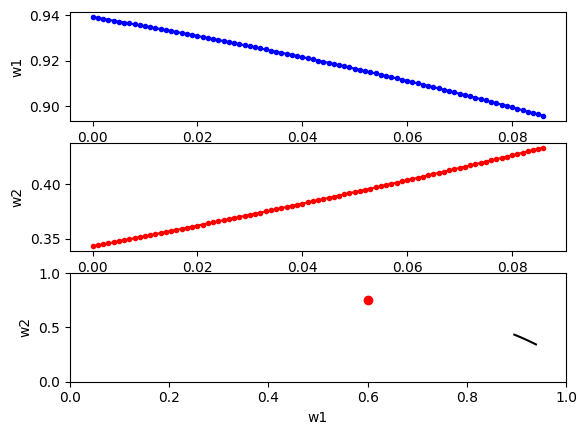

In [413]:
t_sol = sol.t
w1_sol = sol.y[0, :]
w2_sol = sol.y[1, :]

# Graph
plt.subplot(3, 1, 1);
plt.plot(t_sol, w1_sol, '.-b')
plt.xlabel('t'); plt.ylabel('w1');

plt.subplot(3, 1, 2);
plt.plot(t_sol, w2_sol, '.-r')
plt.xlabel('t'); plt.ylabel('w2');

plt.subplot(3, 1, 3);
plt.plot(w1_sol, w2_sol, 'black')
plt.xlabel('w1'); plt.ylabel('w2')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(H_coeffs[0],H_coeffs[1],'ro') 